# Final Project- Group 2

In this notebook, our goal is to conduct a comprehensive analysis of meteorological data for Traverse City. To achieve meaningful insights and build predictive models, we will follow a systematic approach to preprocess the data and engineer relevant features. Our primary focus will be on predicting precipitation based on various meteorological variables.

In [1]:
# pip install -U imbalanced-learn

In [2]:
# Import necessary libraries for data handling, visualization, and modeling

import numpy as np
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix, \
accuracy_score, classification_report, f1_score

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)

## Time-Series Analysis and Precipitation Prediction

We aim to predict precipitation using a time-series approach. Here is our approach:

### Data Preprocessing:

- **Date and Time Handling:** Combine 'Date' and 'Time' columns into a DateTime object.
- **Label Quantization:** Create a new 'precip_class' label by quantizing precipitation into binary categories.

### Feature Engineering:

- **Identify Daily Patterns:** Analyze daily variability and identify patterns within the observed time range (9 am to 6 pm).
- **Experiment with Window Sizes:** Based on insights, experiment with different window sizes for creating sequences.

### Lagged Features for Time Series Modeling:

- To capture temporal dependencies and facilitate time series modeling, we will introduce lagged features. Specifically, we will create lagged versions of the meteorological variables to represent historical values. This step is crucial for training models that can effectively leverage the temporal nature of meteorological data.

### Model Building:

- **LSTM Model:** Train an LSTM model to capture temporal dependencies.
- **Feature Scaling:** Standardize features to ensure the model's stability.

### Evaluation:

- **Model Training:** Train the LSTM RNN model on the training dataset.
- **Validation:** Evaluate the model's performance using different window sizes on a validation set.

### Loading the dataset

In [4]:
df = pd.read_csv(r"C:\Users\hmitt\Downloads\INFO6106_Notebooks\Final Project\2006Fall_2017Spring_GOES_meteo_combined.csv")
df

,Date_UTC,Time_UTC,Date_CST,Time_CST,File_name_for_1D_lake,File_name_for_2D_lake,Lake_data_1D,Lake_data_2D,Temp (F),RH (%),Dewpt (F),Wind Spd (mph),Wind Direction (deg),Peak Wind Gust(mph),Low Cloud Ht (ft),Med Cloud Ht (ft),High Cloud Ht (ft),Visibility (mi),Atm Press (hPa),Sea Lev Press (hPa),Altimeter (hPa),Precip (in),Wind Chill (F),Heat Index (F)
0,2006-10-01,00:00,2006-09-30,18:00,goes11.2006.10.01.0000.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0000.v01.nc-var1-t0.csv.csv,"[0.0075, 0.0025, 0.0, 0.005, 0.0, 0.005, nan, ...","[array([ nan, nan, nan, nan, nan...",51,92,49,0,0,m,3700,m,m,10,984.4,1007.20,1007.10,0.00,NC,NC
1,2006-10-01,01:00,2006-09-30,19:00,goes11.2006.10.01.0100.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0100.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0025, 0.0025, nan, 0.0, nan, 0...","[array([ nan, nan, nan, nan, nan...",48,96,47,0,0,m,3700,m,m,10,984.7,1007.80,1007.50,0.00,NC,NC
2,2006-10-01,02:00,2006-09-30,20:00,goes11.2006.10.01.0200.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0200.v01.nc-var1-t0.csv.csv,"[0.0, nan, 0.0075, nan, nan, 0.0025, nan, nan,...","[array([nan, nan, nan, nan, nan, nan, nan, nan...",49,92,47,3,220,m,3700,m,m,10,985.4,1008.30,1008.10,0.00,NC,NC
3,2006-10-01,03:00,2006-09-30,21:00,goes11.2006.10.01.0300.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0300.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0025, 0.0, 0.0075, nan, 0.005,...","[array([nan, nan, nan, nan, nan, nan, nan, nan...",48,100,48,0,0,m,2500,6500,m,6,986.0,M,1008.80,0.02,NC,NC
4,2006-10-01,04:00,2006-09-30,22:00,goes11.2006.10.01.0400.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0400.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0, nan, 0.0075, 0.0, nan, nan,...","[array([ nan, nan, nan, nan, nan...",50,92,48,3,180,m,7000,m,m,8,986.4,1009.50,1009.10,0.00,NC,NC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48116,2015-03-31,19:00,2015-03-31,13:00,goes15.2015.03.31.1900.v01.nc-var1-t0.csv,T_goes15.2015.03.31.1900.v01.nc-var1-t0.csv.csv,"[0.22, 0.1925, 0.1775, 0.16749999, 0.16499999,...","[array([ nan, nan, nan, ...",44.0,39.0,21.0,8,30,m,3000,7000,15000,10,989.00,1012.20,1011.90,0.00,39,NC
48117,2015-03-31,20:00,2015-03-31,14:00,goes15.2015.03.31.2000.v01.nc-var1-t0.csv,T_goes15.2015.03.31.2000.v01.nc-var1-t0.csv.csv,"[0.2575, 0.22, 0.21249999, 0.17999999, 0.185, ...","[array([ nan, nan, nan, nan, nan...",44.0,43.0,23.0,8,40,m,4000,8000,13000,10,988.70,1012.10,1011.50,0.00,39,NC
48118,2015-03-31,21:00,2015-03-31,15:00,goes15.2015.03.31.2100.v01.nc-var1-t0.csv,T_goes15.2015.03.31.2100.v01.nc-var1-t0.csv.csv,"[0.2225, 0.18249999, 0.19, 0.17999999, 0.1725,...","[array([ nan, nan, nan, nan, nan, nan, n...",40.0,52.0,24.0,7,30,m,9000,m,m,10,988.70,1012.20,1011.50,0.00,35,NC
48119,2015-03-31,22:00,2015-03-31,16:00,goes15.2015.03.31.2200.v01.nc-var1-t0.csv,T_goes15.2015.03.31.2200.v01.nc-var1-t0.csv.csv,"[0.17999999, 0.16749999, 0.16749999, 0.16, 0.1...","[array([ nan, nan, nan, nan, nan...",41.0,46.0,22.0,6,30,m,7500,9000,m,10,989.00,1012.50,1011.90,0.00,37,NC


Following is the description and features in our dataset:

>This dataset appears to contain weather-related information. It includes various weather-related measurements and conditions observed over time. Here's a brief description of each column:
> 
> **Attribute Information**:
> 
> 1. *Date:* Date of the observation.
> 2. *Time:* Time of the observation.
> 3. *Temp (F):* Temperature in degrees Fahrenheit.
> 4. *RH (%):* Relative humidity in percentage.
> 5. *Dewpt (F):* Dew point temperature in degrees Fahrenheit.
> 6. *Wind Spd (mph):* Wind speed in miles per hour.
> 7. *Wind Direction (deg):* Wind direction in degrees.
> 9. *Peak Wind Gust(mph):* Peak wind gust speed in miles per hour.
> 10. *Low Cloud Ht (ft):* Height of low-level clouds in feet.
> 11. *Med Cloud Ht (ft):* Height of medium-level clouds in feet.
> 12. *High Cloud Ht (ft):* Height of high-level clouds in feet.
> 13. *Visibility (mi):* Visibility in miles.
> 14. *Atm Press (hPa):* Atmospheric pressure in hectopascals.
> 15. *Sea Lev Press (hPa):* Sea level pressure in hectopascals.
> 16. *Altimeter (hPa):* Altimeter setting in hectopascals.
> 17. *Precip (in):* Precipitation amount in inches.
> 18. *Wind Chill (F):* Wind chill temperature in degrees Fahrenheit.
> 19. *Heat Index (F):* Heat index temperature in degrees Fahrenheit.

In [5]:
df['DateTime'] = pd.to_datetime(df['Date_UTC'] + ' ' + df['Time_UTC'])
df

,Date_UTC,Time_UTC,Date_CST,Time_CST,File_name_for_1D_lake,File_name_for_2D_lake,Lake_data_1D,Lake_data_2D,Temp (F),RH (%),Dewpt (F),Wind Spd (mph),Wind Direction (deg),Peak Wind Gust(mph),Low Cloud Ht (ft),Med Cloud Ht (ft),High Cloud Ht (ft),Visibility (mi),Atm Press (hPa),Sea Lev Press (hPa),Altimeter (hPa),Precip (in),Wind Chill (F),Heat Index (F),DateTime
0,2006-10-01,00:00,2006-09-30,18:00,goes11.2006.10.01.0000.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0000.v01.nc-var1-t0.csv.csv,"[0.0075, 0.0025, 0.0, 0.005, 0.0, 0.005, nan, ...","[array([ nan, nan, nan, nan, nan...",51,92,49,0,0,m,3700,m,m,10,984.4,1007.20,1007.10,0.00,NC,NC,2006-10-01 00:00:00
1,2006-10-01,01:00,2006-09-30,19:00,goes11.2006.10.01.0100.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0100.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0025, 0.0025, nan, 0.0, nan, 0...","[array([ nan, nan, nan, nan, nan...",48,96,47,0,0,m,3700,m,m,10,984.7,1007.80,1007.50,0.00,NC,NC,2006-10-01 01:00:00
2,2006-10-01,02:00,2006-09-30,20:00,goes11.2006.10.01.0200.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0200.v01.nc-var1-t0.csv.csv,"[0.0, nan, 0.0075, nan, nan, 0.0025, nan, nan,...","[array([nan, nan, nan, nan, nan, nan, nan, nan...",49,92,47,3,220,m,3700,m,m,10,985.4,1008.30,1008.10,0.00,NC,NC,2006-10-01 02:00:00
3,2006-10-01,03:00,2006-09-30,21:00,goes11.2006.10.01.0300.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0300.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0025, 0.0, 0.0075, nan, 0.005,...","[array([nan, nan, nan, nan, nan, nan, nan, nan...",48,100,48,0,0,m,2500,6500,m,6,986.0,M,1008.80,0.02,NC,NC,2006-10-01 03:00:00
4,2006-10-01,04:00,2006-09-30,22:00,goes11.2006.10.01.0400.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0400.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0, nan, 0.0075, 0.0, nan, nan,...","[array([ nan, nan, nan, nan, nan...",50,92,48,3,180,m,7000,m,m,8,986.4,1009.50,1009.10,0.00,NC,NC,2006-10-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48116,2015-03-31,19:00,2015-03-31,13:00,goes15.2015.03.31.1900.v01.nc-var1-t0.csv,T_goes15.2015.03.31.1900.v01.nc-var1-t0.csv.csv,"[0.22, 0.1925, 0.1775, 0.16749999, 0.16499999,...","[array([ nan, nan, nan, ...",44.0,39.0,21.0,8,30,m,3000,7000,15000,10,989.00,1012.20,1011.90,0.00,39,NC,2015-03-31 19:00:00
48117,2015-03-31,20:00,2015-03-31,14:00,goes15.2015.03.31.2000.v01.nc-var1-t0.csv,T_goes15.2015.03.31.2000.v01.nc-var1-t0.csv.csv,"[0.2575, 0.22, 0.21249999, 0.17999999, 0.185, ...","[array([ nan, nan, nan, nan, nan...",44.0,43.0,23.0,8,40,m,4000,8000,13000,10,988.70,1012.10,1011.50,0.00,39,NC,2015-03-31 20:00:00
48118,2015-03-31,21:00,2015-03-31,15:00,goes15.2015.03.31.2100.v01.nc-var1-t0.csv,T_goes15.2015.03.31.2100.v01.nc-var1-t0.csv.csv,"[0.2225, 0.18249999, 0.19, 0.17999999, 0.1725,...","[array([ nan, nan, nan, nan, nan, nan, n...",40.0,52.0,24.0,7,30,m,9000,m,m,10,988.70,1012.20,1011.50,0.00,35,NC,2015-03-31 21:00:00
48119,2015-03-31,22:00,2015-03-31,16:00,goes15.2015.03.31.2200.v01.nc-var1-t0.csv,T_goes15.2015.03.31.2200.v01.nc-var1-t0.csv.csv,"[0.17999999, 0.16749999, 0.16749999, 0.16, 0.1...","[array([ nan, nan, nan, nan, nan...",41.0,46.0,22.0,6,30,m,7500,9000,m,10,989.00,1012.50,1011.90,0.00,37,NC,2015-03-31 22:00:00


In [6]:
df.drop(['Date_UTC','Time_UTC','Date_CST','Time_CST','File_name_for_1D_lake','File_name_for_2D_lake','Lake_data_1D','Lake_data_2D'], axis=1, inplace=True)
df

,Temp (F),RH (%),Dewpt (F),Wind Spd (mph),Wind Direction (deg),Peak Wind Gust(mph),Low Cloud Ht (ft),Med Cloud Ht (ft),High Cloud Ht (ft),Visibility (mi),Atm Press (hPa),Sea Lev Press (hPa),Altimeter (hPa),Precip (in),Wind Chill (F),Heat Index (F),DateTime
0,51,92,49,0,0,m,3700,m,m,10,984.4,1007.20,1007.10,0.00,NC,NC,2006-10-01 00:00:00
1,48,96,47,0,0,m,3700,m,m,10,984.7,1007.80,1007.50,0.00,NC,NC,2006-10-01 01:00:00
2,49,92,47,3,220,m,3700,m,m,10,985.4,1008.30,1008.10,0.00,NC,NC,2006-10-01 02:00:00
3,48,100,48,0,0,m,2500,6500,m,6,986.0,M,1008.80,0.02,NC,NC,2006-10-01 03:00:00
4,50,92,48,3,180,m,7000,m,m,8,986.4,1009.50,1009.10,0.00,NC,NC,2006-10-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48116,44.0,39.0,21.0,8,30,m,3000,7000,15000,10,989.00,1012.20,1011.90,0.00,39,NC,2015-03-31 19:00:00
48117,44.0,43.0,23.0,8,40,m,4000,8000,13000,10,988.70,1012.10,1011.50,0.00,39,NC,2015-03-31 20:00:00
48118,40.0,52.0,24.0,7,30,m,9000,m,m,10,988.70,1012.20,1011.50,0.00,35,NC,2015-03-31 21:00:00
48119,41.0,46.0,22.0,6,30,m,7500,9000,m,10,989.00,1012.50,1011.90,0.00,37,NC,2015-03-31 22:00:00


In [7]:
# Identifying the data-type of each columnm in the dataset.

dtype = {}
for column in df.columns:
    dtype[column] = df[column].dtype
dtype

{'Temp (F)': dtype('O'),
 'RH (%)': dtype('O'),
 'Dewpt (F)': dtype('O'),
 'Wind Spd (mph)': dtype('O'),
 'Wind Direction (deg)': dtype('O'),
 'Peak Wind Gust(mph)': dtype('O'),
 'Low Cloud Ht (ft)': dtype('O'),
 'Med Cloud Ht (ft)': dtype('O'),
 'High Cloud Ht (ft)': dtype('O'),
 'Visibility (mi)': dtype('O'),
 'Atm Press (hPa)': dtype('O'),
 'Sea Lev Press (hPa)': dtype('O'),
 'Altimeter (hPa)': dtype('O'),
 'Precip (in)': dtype('O'),
 'Wind Chill (F)': dtype('O'),
 'Heat Index (F)': dtype('O'),
 'DateTime': dtype('<M8[ns]')}

In [8]:
# Define the time range
start_time = pd.to_datetime('14:00:00').time()
end_time = pd.to_datetime('22:00:00').time()

# Filter the DataFrame based on the time range
filtered_df = df[(df['DateTime'].dt.time >= start_time) & (df['DateTime'].dt.time <= end_time)]
filtered_df

,Temp (F),RH (%),Dewpt (F),Wind Spd (mph),Wind Direction (deg),Peak Wind Gust(mph),Low Cloud Ht (ft),Med Cloud Ht (ft),High Cloud Ht (ft),Visibility (mi),Atm Press (hPa),Sea Lev Press (hPa),Altimeter (hPa),Precip (in),Wind Chill (F),Heat Index (F),DateTime
14,48,92,46,0,0,m,3600,m,m,10,993.0,1016.30,1015.90,0.00,NC,NC,2006-10-01 14:00:00
15,55,59,41,11,300,m,3600,m,m,10,993.7,1016.90,1016.60,0.00,NC,NC,2006-10-01 15:00:00
16,55,61,42,10,300,m,3600,m,m,10,994.3,1017.50,1017.30,0.00,NC,NC,2006-10-01 16:00:00
17,58,55,42,8,290,m,3600,m,m,10,995.0,1018.00,1017.90,0.00,NC,NC,2006-10-01 17:00:00
18,56,59,42,10,260,m,3600,m,m,10,995.0,1018.10,1017.90,0.00,NC,NC,2006-10-01 18:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48115,44.0,43.0,23.0,9,20,m,2000,15000,25000,10,989.30,1012.70,1012.20,0.00,39,NC,2015-03-31 18:00:00
48116,44.0,39.0,21.0,8,30,m,3000,7000,15000,10,989.00,1012.20,1011.90,0.00,39,NC,2015-03-31 19:00:00
48117,44.0,43.0,23.0,8,40,m,4000,8000,13000,10,988.70,1012.10,1011.50,0.00,39,NC,2015-03-31 20:00:00
48118,40.0,52.0,24.0,7,30,m,9000,m,m,10,988.70,1012.20,1011.50,0.00,35,NC,2015-03-31 21:00:00


In [9]:
filtered_df['DateTime'].min()

Timestamp('2006-10-01 14:00:00')

In [10]:
filtered_df['DateTime'].max()

Timestamp('2017-03-31 22:00:00')

### Data cleaning and preprocessing

Let's observe some of the features which are marked as having 'Object' datatype.

In [11]:
filtered_df['Heat Index (F)'].value_counts()

NC    17882
80       13
M        12
81        9
82        8
86        8
84        6
85        5
83        4
88        2
87        2
90        2
89        1
Name: Heat Index (F), dtype: int64

In [12]:
filtered_df['Wind Chill (F)'].value_counts()

NC     5969
24      389
21      382
22      375
32      373
       ... 
-25       2
-24       1
-26       1
-27       1
-29       1
Name: Wind Chill (F), Length: 79, dtype: int64

In [13]:
# Dropping "Heat Index (F)" and "Wind Chill (F)" columns since majority datapoints don't carry any useful value.\
# NC: Wind Chill/Heat Index do not meet the required thresholds to be calculated.

filtered_df.drop(["Heat Index (F)","Wind Chill (F)"], axis=1, inplace=True)

C:\Users\hmitt\anaconda3\envs\conx\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [14]:
filtered_df['Sea Lev Press (hPa)'].value_counts()

M          1070
1018.10      94
1017.40      91
1017.10      90
1017.90      90
           ... 
985.40        1
984.60        1
991.10        1
984.00        1
1038.70       1
Name: Sea Lev Press (hPa), Length: 566, dtype: int64

In [15]:
filtered_df['Wind Direction (deg)'].value_counts()

M      1804
0      1631
250     797
260     762
240     660
230     633
270     621
280     556
220     520
340     517
300     507
350     492
290     487
30      483
10      463
200     462
310     458
210     457
330     444
20      444
360     438
320     412
190     347
40      335
160     326
150     304
180     303
140     286
170     283
50      243
130     242
120     206
60      197
110     187
90      167
70      161
80      160
100     159
Name: Wind Direction (deg), dtype: int64

In [16]:
filtered_df['High Cloud Ht (ft)'].value_counts()

m        15422
25000      362
20000      210
6000       133
5000       133
         ...  
4430         1
4630         1
9840         1
3640         1
6890         1
Name: High Cloud Ht (ft), Length: 72, dtype: int64

We observe that our dataset contains the value 'm' or 'M' for various datapoints across multiple features. This represents missing values and needs to be managed. To handle these missing values effectively, we can consider the following strategies:

* Imputation with a Specific Value
* Numeric Conversion
* Data Imputation Techniques to fill missing values with meaningful estimates like mean, median, mode imputation.
* Dropping Rows or Columns

We shall perform simple data preprocessing task by replacing all occurrences of 'm' or 'M' with '0' in the specified column of the DataFrame 'df'. This allows for consistent handling of missing data.

In [17]:
filtered_df

,Temp (F),RH (%),Dewpt (F),Wind Spd (mph),Wind Direction (deg),Peak Wind Gust(mph),Low Cloud Ht (ft),Med Cloud Ht (ft),High Cloud Ht (ft),Visibility (mi),Atm Press (hPa),Sea Lev Press (hPa),Altimeter (hPa),Precip (in),DateTime
14,48,92,46,0,0,m,3600,m,m,10,993.0,1016.30,1015.90,0.00,2006-10-01 14:00:00
15,55,59,41,11,300,m,3600,m,m,10,993.7,1016.90,1016.60,0.00,2006-10-01 15:00:00
16,55,61,42,10,300,m,3600,m,m,10,994.3,1017.50,1017.30,0.00,2006-10-01 16:00:00
17,58,55,42,8,290,m,3600,m,m,10,995.0,1018.00,1017.90,0.00,2006-10-01 17:00:00
18,56,59,42,10,260,m,3600,m,m,10,995.0,1018.10,1017.90,0.00,2006-10-01 18:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48115,44.0,43.0,23.0,9,20,m,2000,15000,25000,10,989.30,1012.70,1012.20,0.00,2015-03-31 18:00:00
48116,44.0,39.0,21.0,8,30,m,3000,7000,15000,10,989.00,1012.20,1011.90,0.00,2015-03-31 19:00:00
48117,44.0,43.0,23.0,8,40,m,4000,8000,13000,10,988.70,1012.10,1011.50,0.00,2015-03-31 20:00:00
48118,40.0,52.0,24.0,7,30,m,9000,m,m,10,988.70,1012.20,1011.50,0.00,2015-03-31 21:00:00


In [18]:
filtered_df = filtered_df.replace(['m','M'], '0')
filtered_df

,Temp (F),RH (%),Dewpt (F),Wind Spd (mph),Wind Direction (deg),Peak Wind Gust(mph),Low Cloud Ht (ft),Med Cloud Ht (ft),High Cloud Ht (ft),Visibility (mi),Atm Press (hPa),Sea Lev Press (hPa),Altimeter (hPa),Precip (in),DateTime
14,48,92,46,0,0,0,3600,0,0,10,993.0,1016.30,1015.90,0.00,2006-10-01 14:00:00
15,55,59,41,11,300,0,3600,0,0,10,993.7,1016.90,1016.60,0.00,2006-10-01 15:00:00
16,55,61,42,10,300,0,3600,0,0,10,994.3,1017.50,1017.30,0.00,2006-10-01 16:00:00
17,58,55,42,8,290,0,3600,0,0,10,995.0,1018.00,1017.90,0.00,2006-10-01 17:00:00
18,56,59,42,10,260,0,3600,0,0,10,995.0,1018.10,1017.90,0.00,2006-10-01 18:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48115,44.0,43.0,23.0,9,20,0,2000,15000,25000,10,989.30,1012.70,1012.20,0.00,2015-03-31 18:00:00
48116,44.0,39.0,21.0,8,30,0,3000,7000,15000,10,989.00,1012.20,1011.90,0.00,2015-03-31 19:00:00
48117,44.0,43.0,23.0,8,40,0,4000,8000,13000,10,988.70,1012.10,1011.50,0.00,2015-03-31 20:00:00
48118,40.0,52.0,24.0,7,30,0,9000,0,0,10,988.70,1012.20,1011.50,0.00,2015-03-31 21:00:00


In [19]:
# We need to ensure consistent handling of missing data and convert columns to integers:
# 1. Replace all occurrences of 'm' and 'M' with '0' to handle missing values.
# 2. Convert the entire column to an integer data type.

columns_to_update = ['Temp (F)','RH (%)','Dewpt (F)','Wind Spd (mph)','Wind Direction (deg)','Peak Wind Gust(mph)','Low Cloud Ht (ft)','Med Cloud Ht (ft)','High Cloud Ht (ft)','Visibility (mi)', 'Atm Press (hPa)', 'Sea Lev Press (hPa)', 'Altimeter (hPa)', 'Precip (in)']
for column in columns_to_update:
    filtered_df[column] = filtered_df[column].astype(float)
filtered_df

,Temp (F),RH (%),Dewpt (F),Wind Spd (mph),Wind Direction (deg),Peak Wind Gust(mph),Low Cloud Ht (ft),Med Cloud Ht (ft),High Cloud Ht (ft),Visibility (mi),Atm Press (hPa),Sea Lev Press (hPa),Altimeter (hPa),Precip (in),DateTime
14,48.0,92.0,46.0,0.0,0.0,0.0,3600.0,0.0,0.0,10.0,993.0,1016.3,1015.9,0.0,2006-10-01 14:00:00
15,55.0,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.0,2006-10-01 15:00:00
16,55.0,61.0,42.0,10.0,300.0,0.0,3600.0,0.0,0.0,10.0,994.3,1017.5,1017.3,0.0,2006-10-01 16:00:00
17,58.0,55.0,42.0,8.0,290.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.0,1017.9,0.0,2006-10-01 17:00:00
18,56.0,59.0,42.0,10.0,260.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.0,2006-10-01 18:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48115,44.0,43.0,23.0,9.0,20.0,0.0,2000.0,15000.0,25000.0,10.0,989.3,1012.7,1012.2,0.0,2015-03-31 18:00:00
48116,44.0,39.0,21.0,8.0,30.0,0.0,3000.0,7000.0,15000.0,10.0,989.0,1012.2,1011.9,0.0,2015-03-31 19:00:00
48117,44.0,43.0,23.0,8.0,40.0,0.0,4000.0,8000.0,13000.0,10.0,988.7,1012.1,1011.5,0.0,2015-03-31 20:00:00
48118,40.0,52.0,24.0,7.0,30.0,0.0,9000.0,0.0,0.0,10.0,988.7,1012.2,1011.5,0.0,2015-03-31 21:00:00


In [20]:
# Identifying the data-type of each columnm in the dataset.

dtype = {}
for column in filtered_df.columns:
    dtype[column] = filtered_df[column].dtype
dtype

{'Temp (F)': dtype('float64'),
 'RH (%)': dtype('float64'),
 'Dewpt (F)': dtype('float64'),
 'Wind Spd (mph)': dtype('float64'),
 'Wind Direction (deg)': dtype('float64'),
 'Peak Wind Gust(mph)': dtype('float64'),
 'Low Cloud Ht (ft)': dtype('float64'),
 'Med Cloud Ht (ft)': dtype('float64'),
 'High Cloud Ht (ft)': dtype('float64'),
 'Visibility (mi)': dtype('float64'),
 'Atm Press (hPa)': dtype('float64'),
 'Sea Lev Press (hPa)': dtype('float64'),
 'Altimeter (hPa)': dtype('float64'),
 'Precip (in)': dtype('float64'),
 'DateTime': dtype('<M8[ns]')}

In [21]:
# Checking for NULL values.

filtered_df.isnull().sum()

Temp (F)                91
RH (%)                  91
Dewpt (F)               91
Wind Spd (mph)          91
Wind Direction (deg)    91
Peak Wind Gust(mph)     91
Low Cloud Ht (ft)       91
Med Cloud Ht (ft)       91
High Cloud Ht (ft)      91
Visibility (mi)         91
Atm Press (hPa)         91
Sea Lev Press (hPa)     91
Altimeter (hPa)         91
Precip (in)             91
DateTime                 0
dtype: int64

In [22]:
filtered_df[filtered_df['Precip (in)'].isnull()]

,Temp (F),RH (%),Dewpt (F),Wind Spd (mph),Wind Direction (deg),Peak Wind Gust(mph),Low Cloud Ht (ft),Med Cloud Ht (ft),High Cloud Ht (ft),Visibility (mi),Atm Press (hPa),Sea Lev Press (hPa),Altimeter (hPa),Precip (in),DateTime
21639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-03-22 14:00:00
21640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-03-22 15:00:00
21641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-03-22 16:00:00
21642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-03-22 17:00:00
21643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-03-22 18:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-03-31 19:00:00
21861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-03-31 20:00:00
21862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-03-31 21:00:00
21863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-03-31 22:00:00


In [23]:
# Define the time range
start_date = pd.to_datetime('2014-03-22 14:00:00')
end_date = pd.to_datetime('2014-03-31 22:00:00')

# Filter the DataFrame based on the time range
filtered_df = filtered_df[(filtered_df['DateTime'] < start_date) | (filtered_df['DateTime'] > end_date)]
filtered_df

,Temp (F),RH (%),Dewpt (F),Wind Spd (mph),Wind Direction (deg),Peak Wind Gust(mph),Low Cloud Ht (ft),Med Cloud Ht (ft),High Cloud Ht (ft),Visibility (mi),Atm Press (hPa),Sea Lev Press (hPa),Altimeter (hPa),Precip (in),DateTime
14,48.0,92.0,46.0,0.0,0.0,0.0,3600.0,0.0,0.0,10.0,993.0,1016.3,1015.9,0.0,2006-10-01 14:00:00
15,55.0,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.0,2006-10-01 15:00:00
16,55.0,61.0,42.0,10.0,300.0,0.0,3600.0,0.0,0.0,10.0,994.3,1017.5,1017.3,0.0,2006-10-01 16:00:00
17,58.0,55.0,42.0,8.0,290.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.0,1017.9,0.0,2006-10-01 17:00:00
18,56.0,59.0,42.0,10.0,260.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.0,2006-10-01 18:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48115,44.0,43.0,23.0,9.0,20.0,0.0,2000.0,15000.0,25000.0,10.0,989.3,1012.7,1012.2,0.0,2015-03-31 18:00:00
48116,44.0,39.0,21.0,8.0,30.0,0.0,3000.0,7000.0,15000.0,10.0,989.0,1012.2,1011.9,0.0,2015-03-31 19:00:00
48117,44.0,43.0,23.0,8.0,40.0,0.0,4000.0,8000.0,13000.0,10.0,988.7,1012.1,1011.5,0.0,2015-03-31 20:00:00
48118,40.0,52.0,24.0,7.0,30.0,0.0,9000.0,0.0,0.0,10.0,988.7,1012.2,1011.5,0.0,2015-03-31 21:00:00


In [24]:
filtered_df.isnull().sum()

Temp (F)                1
RH (%)                  1
Dewpt (F)               1
Wind Spd (mph)          1
Wind Direction (deg)    1
Peak Wind Gust(mph)     1
Low Cloud Ht (ft)       1
Med Cloud Ht (ft)       1
High Cloud Ht (ft)      1
Visibility (mi)         1
Atm Press (hPa)         1
Sea Lev Press (hPa)     1
Altimeter (hPa)         1
Precip (in)             1
DateTime                0
dtype: int64

In [25]:
filtered_df = filtered_df.fillna(0)
filtered_df

,Temp (F),RH (%),Dewpt (F),Wind Spd (mph),Wind Direction (deg),Peak Wind Gust(mph),Low Cloud Ht (ft),Med Cloud Ht (ft),High Cloud Ht (ft),Visibility (mi),Atm Press (hPa),Sea Lev Press (hPa),Altimeter (hPa),Precip (in),DateTime
14,48.0,92.0,46.0,0.0,0.0,0.0,3600.0,0.0,0.0,10.0,993.0,1016.3,1015.9,0.0,2006-10-01 14:00:00
15,55.0,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.0,2006-10-01 15:00:00
16,55.0,61.0,42.0,10.0,300.0,0.0,3600.0,0.0,0.0,10.0,994.3,1017.5,1017.3,0.0,2006-10-01 16:00:00
17,58.0,55.0,42.0,8.0,290.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.0,1017.9,0.0,2006-10-01 17:00:00
18,56.0,59.0,42.0,10.0,260.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.0,2006-10-01 18:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48115,44.0,43.0,23.0,9.0,20.0,0.0,2000.0,15000.0,25000.0,10.0,989.3,1012.7,1012.2,0.0,2015-03-31 18:00:00
48116,44.0,39.0,21.0,8.0,30.0,0.0,3000.0,7000.0,15000.0,10.0,989.0,1012.2,1011.9,0.0,2015-03-31 19:00:00
48117,44.0,43.0,23.0,8.0,40.0,0.0,4000.0,8000.0,13000.0,10.0,988.7,1012.1,1011.5,0.0,2015-03-31 20:00:00
48118,40.0,52.0,24.0,7.0,30.0,0.0,9000.0,0.0,0.0,10.0,988.7,1012.2,1011.5,0.0,2015-03-31 21:00:00


In [26]:
filtered_df.isnull().sum()

Temp (F)                0
RH (%)                  0
Dewpt (F)               0
Wind Spd (mph)          0
Wind Direction (deg)    0
Peak Wind Gust(mph)     0
Low Cloud Ht (ft)       0
Med Cloud Ht (ft)       0
High Cloud Ht (ft)      0
Visibility (mi)         0
Atm Press (hPa)         0
Sea Lev Press (hPa)     0
Altimeter (hPa)         0
Precip (in)             0
DateTime                0
dtype: int64

In [27]:
filtered_df_sorted = filtered_df.sort_values(by='DateTime')
filtered_df_sorted

,Temp (F),RH (%),Dewpt (F),Wind Spd (mph),Wind Direction (deg),Peak Wind Gust(mph),Low Cloud Ht (ft),Med Cloud Ht (ft),High Cloud Ht (ft),Visibility (mi),Atm Press (hPa),Sea Lev Press (hPa),Altimeter (hPa),Precip (in),DateTime
14,48.0,92.0,46.0,0.0,0.0,0.0,3600.0,0.0,0.0,10.0,993.0,1016.3,1015.9,0.0,2006-10-01 14:00:00
15,55.0,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.0,2006-10-01 15:00:00
16,55.0,61.0,42.0,10.0,300.0,0.0,3600.0,0.0,0.0,10.0,994.3,1017.5,1017.3,0.0,2006-10-01 16:00:00
17,58.0,55.0,42.0,8.0,290.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.0,1017.9,0.0,2006-10-01 17:00:00
18,56.0,59.0,42.0,10.0,260.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.0,2006-10-01 18:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13098,39.0,75.0,32.0,10.0,20.0,0.0,2000.0,0.0,0.0,10.0,988.7,1011.9,1011.5,0.0,2017-03-31 18:00:00
13099,39.0,75.0,32.0,10.0,20.0,0.0,2100.0,0.0,0.0,10.0,989.0,1012.3,1011.9,0.0,2017-03-31 19:00:00
13100,40.0,73.0,32.0,9.0,20.0,0.0,2200.0,0.0,0.0,10.0,989.3,1012.6,1012.2,0.0,2017-03-31 20:00:00
13101,41.0,70.0,32.0,8.0,20.0,0.0,2600.0,3000.0,3700.0,10.0,989.7,1013.1,1012.5,0.0,2017-03-31 21:00:00


In [28]:
# Calculate the correlation matrix between all features
correlation_matrix = filtered_df_sorted.corr()

# Extract the correlation values for 'Precip (in)'
correlation_with_precip = correlation_matrix['Precip (in)']


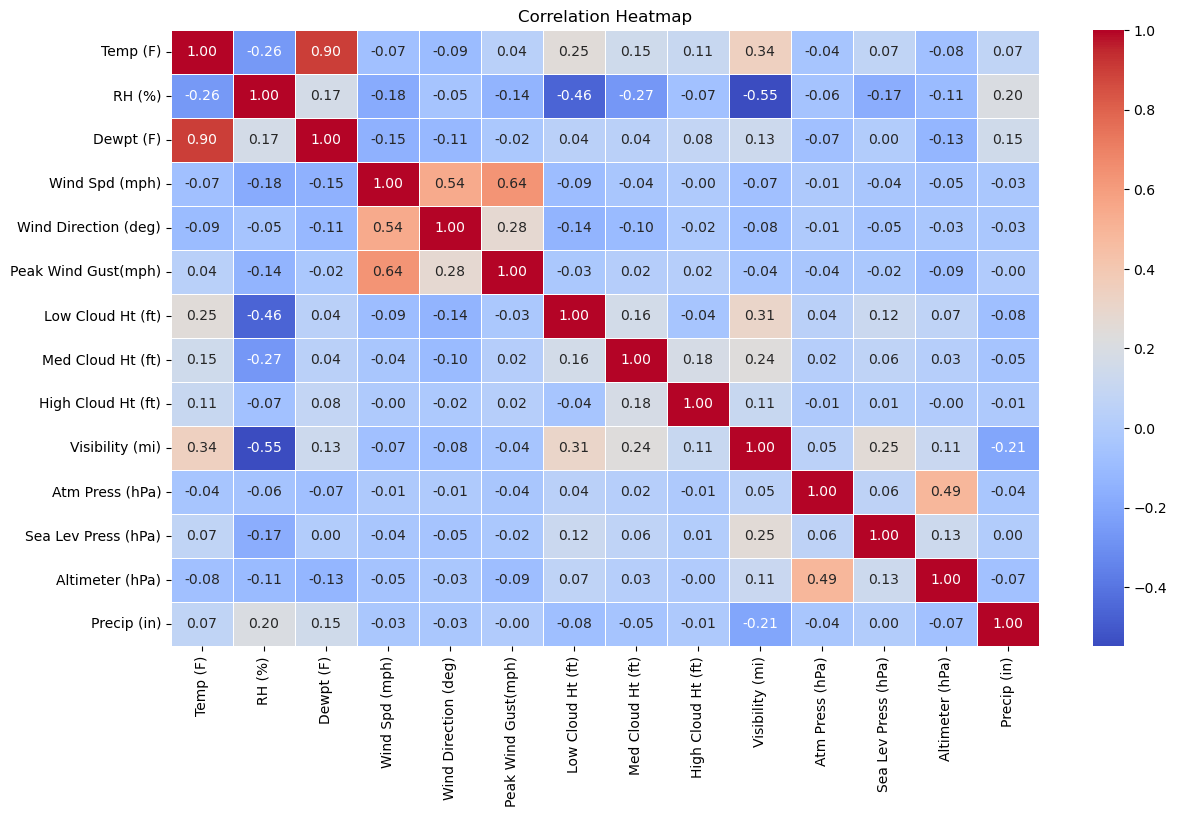

In [29]:
# Create a heatmap
plt.figure(figsize=(14, 8))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Set the title
plt.title('Correlation Heatmap')

# Display the plot
plt.show()

In [30]:
correlation_with_precip

Temp (F)                0.068817
RH (%)                  0.202662
Dewpt (F)               0.152237
Wind Spd (mph)         -0.031640
Wind Direction (deg)   -0.032841
Peak Wind Gust(mph)    -0.001548
Low Cloud Ht (ft)      -0.078242
Med Cloud Ht (ft)      -0.050038
High Cloud Ht (ft)     -0.011109
Visibility (mi)        -0.206673
Atm Press (hPa)        -0.037614
Sea Lev Press (hPa)     0.004008
Altimeter (hPa)        -0.065661
Precip (in)             1.000000
Name: Precip (in), dtype: float64

From the correlation values between 'Precip (in)' and other features, it can be observed that:

* 'RH (%)' (Relative Humidity) has a relatively high positive correlation (0.213964) with 'Precip (in)', suggesting that higher relative humidity is associated with more precipitation.
* 'Visibility (mi)' has a significant negative correlation (-0.309092) with 'Precip (in)', indicating that reduced visibility often accompanies higher levels of precipitation.
* 'Atm Press (hPa)' (Atmospheric Pressure) and 'Altimeter (hPa)' have negative correlations with 'Precip (in)' but are not as strong as 'RH (%)' and 'Visibility (mi)'.

These correlations provide insights into how various meteorological features are related to precipitation levels. For example, higher relative humidity and reduced visibility tend to be associated with increased precipitation, while atmospheric pressure shows a negative but less pronounced relationship with precipitation.

In [31]:
filtered_df_sorted = filtered_df_sorted.drop(['Temp (F)'], axis=1)
filtered_df_sorted

,RH (%),Dewpt (F),Wind Spd (mph),Wind Direction (deg),Peak Wind Gust(mph),Low Cloud Ht (ft),Med Cloud Ht (ft),High Cloud Ht (ft),Visibility (mi),Atm Press (hPa),Sea Lev Press (hPa),Altimeter (hPa),Precip (in),DateTime
14,92.0,46.0,0.0,0.0,0.0,3600.0,0.0,0.0,10.0,993.0,1016.3,1015.9,0.0,2006-10-01 14:00:00
15,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.0,2006-10-01 15:00:00
16,61.0,42.0,10.0,300.0,0.0,3600.0,0.0,0.0,10.0,994.3,1017.5,1017.3,0.0,2006-10-01 16:00:00
17,55.0,42.0,8.0,290.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.0,1017.9,0.0,2006-10-01 17:00:00
18,59.0,42.0,10.0,260.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.0,2006-10-01 18:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13098,75.0,32.0,10.0,20.0,0.0,2000.0,0.0,0.0,10.0,988.7,1011.9,1011.5,0.0,2017-03-31 18:00:00
13099,75.0,32.0,10.0,20.0,0.0,2100.0,0.0,0.0,10.0,989.0,1012.3,1011.9,0.0,2017-03-31 19:00:00
13100,73.0,32.0,9.0,20.0,0.0,2200.0,0.0,0.0,10.0,989.3,1012.6,1012.2,0.0,2017-03-31 20:00:00
13101,70.0,32.0,8.0,20.0,0.0,2600.0,3000.0,3700.0,10.0,989.7,1013.1,1012.5,0.0,2017-03-31 21:00:00


In [32]:
filtered_df_sorted.head(48)

,RH (%),Dewpt (F),Wind Spd (mph),Wind Direction (deg),Peak Wind Gust(mph),Low Cloud Ht (ft),Med Cloud Ht (ft),High Cloud Ht (ft),Visibility (mi),Atm Press (hPa),Sea Lev Press (hPa),Altimeter (hPa),Precip (in),DateTime
14,92.0,46.0,0.0,0.0,0.0,3600.0,0.0,0.0,10.0,993.0,1016.3,1015.9,0.0,2006-10-01 14:00:00
15,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.0,2006-10-01 15:00:00
16,61.0,42.0,10.0,300.0,0.0,3600.0,0.0,0.0,10.0,994.3,1017.5,1017.3,0.0,2006-10-01 16:00:00
17,55.0,42.0,8.0,290.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.0,1017.9,0.0,2006-10-01 17:00:00
18,59.0,42.0,10.0,260.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.0,2006-10-01 18:00:00
19,53.0,43.0,9.0,300.0,0.0,3800.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.0,2006-10-01 19:00:00
20,49.0,41.0,10.0,270.0,0.0,3600.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.0,2006-10-01 20:00:00
21,47.0,40.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.7,1017.6,0.0,2006-10-01 21:00:00
22,55.0,43.0,6.0,40.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.0,2006-10-01 22:00:00
38,65.0,54.0,8.0,170.0,0.0,8000.0,0.0,0.0,10.0,991.0,1013.9,1013.9,0.0,2006-10-02 14:00:00


In [33]:
filtered_df_sorted = filtered_df_sorted[['DateTime','RH (%)','Dewpt (F)','Peak Wind Gust(mph)','Visibility (mi)','Atm Press (hPa)','Altimeter (hPa)', 'Precip (in)']]
filtered_df_sorted

,DateTime,RH (%),Dewpt (F),Peak Wind Gust(mph),Visibility (mi),Atm Press (hPa),Altimeter (hPa),Precip (in)
14,2006-10-01 14:00:00,92.0,46.0,0.0,10.0,993.0,1015.9,0.0
15,2006-10-01 15:00:00,59.0,41.0,0.0,10.0,993.7,1016.6,0.0
16,2006-10-01 16:00:00,61.0,42.0,0.0,10.0,994.3,1017.3,0.0
17,2006-10-01 17:00:00,55.0,42.0,0.0,10.0,995.0,1017.9,0.0
18,2006-10-01 18:00:00,59.0,42.0,0.0,10.0,995.0,1017.9,0.0
...,...,...,...,...,...,...,...,...
13098,2017-03-31 18:00:00,75.0,32.0,0.0,10.0,988.7,1011.5,0.0
13099,2017-03-31 19:00:00,75.0,32.0,0.0,10.0,989.0,1011.9,0.0
13100,2017-03-31 20:00:00,73.0,32.0,0.0,10.0,989.3,1012.2,0.0
13101,2017-03-31 21:00:00,70.0,32.0,0.0,10.0,989.7,1012.5,0.0


In [34]:
weather_data = filtered_df_sorted.set_index('DateTime')
weather_data

,RH (%),Dewpt (F),Peak Wind Gust(mph),Visibility (mi),Atm Press (hPa),Altimeter (hPa),Precip (in)
DateTime,,,,,,,
2006-10-01 14:00:00,92.0,46.0,0.0,10.0,993.0,1015.9,0.0
2006-10-01 15:00:00,59.0,41.0,0.0,10.0,993.7,1016.6,0.0
2006-10-01 16:00:00,61.0,42.0,0.0,10.0,994.3,1017.3,0.0
2006-10-01 17:00:00,55.0,42.0,0.0,10.0,995.0,1017.9,0.0
2006-10-01 18:00:00,59.0,42.0,0.0,10.0,995.0,1017.9,0.0
...,...,...,...,...,...,...,...
2017-03-31 18:00:00,75.0,32.0,0.0,10.0,988.7,1011.5,0.0
2017-03-31 19:00:00,75.0,32.0,0.0,10.0,989.0,1011.9,0.0
2017-03-31 20:00:00,73.0,32.0,0.0,10.0,989.3,1012.2,0.0


### Lagged Features for Time Series Modeling:

To capture temporal dependencies and facilitate time series modeling, we will introduce lagged features. Specifically, we will create lagged versions of the meteorological variables to represent historical values. This step is crucial for training models that can effectively leverage the temporal nature of meteorological data.

For each hour data, we will capture lagged features of past 9 hours. This means we are using meteo data from previous day to predict the precipitation for next day.

In [35]:
# Feature engineering: create lagged features for the past 3 days
for i in range(10, 19):
    for column in ['RH (%)','Dewpt (F)','Peak Wind Gust(mph)','Visibility (mi)',
                   'Atm Press (hPa)','Altimeter (hPa)', 'Precip (in)']:
        weather_data[f'{column}_lag{i}'] = weather_data[column].shift(i)

# Drop rows with NaN values introduced by lagging
weather_data = weather_data.dropna()

In [36]:
weather_data

,RH (%),Dewpt (F),Peak Wind Gust(mph),Visibility (mi),Atm Press (hPa),Altimeter (hPa),Precip (in),RH (%)_lag10,Dewpt (F)_lag10,Peak Wind Gust(mph)_lag10,Visibility (mi)_lag10,Atm Press (hPa)_lag10,Altimeter (hPa)_lag10,Precip (in)_lag10,RH (%)_lag11,Dewpt (F)_lag11,Peak Wind Gust(mph)_lag11,Visibility (mi)_lag11,Atm Press (hPa)_lag11,Altimeter (hPa)_lag11,Precip (in)_lag11,RH (%)_lag12,Dewpt (F)_lag12,Peak Wind Gust(mph)_lag12,Visibility (mi)_lag12,Atm Press (hPa)_lag12,Altimeter (hPa)_lag12,Precip (in)_lag12,RH (%)_lag13,Dewpt (F)_lag13,Peak Wind Gust(mph)_lag13,Visibility (mi)_lag13,Atm Press (hPa)_lag13,Altimeter (hPa)_lag13,Precip (in)_lag13,RH (%)_lag14,Dewpt (F)_lag14,Peak Wind Gust(mph)_lag14,Visibility (mi)_lag14,Atm Press (hPa)_lag14,Altimeter (hPa)_lag14,Precip (in)_lag14,RH (%)_lag15,Dewpt (F)_lag15,Peak Wind Gust(mph)_lag15,Visibility (mi)_lag15,Atm Press (hPa)_lag15,Altimeter (hPa)_lag15,Precip (in)_lag15,RH (%)_lag16,Dewpt (F)_lag16,Peak Wind Gust(mph)_lag16,Visibility (mi)_lag16,Atm Press (hPa)_lag16,Altimeter (hPa)_lag16,Precip (in)_lag16,RH (%)_lag17,Dewpt (F)_lag17,Peak Wind Gust(mph)_lag17,Visibility (mi)_lag17,Atm Press (hPa)_lag17,Altimeter (hPa)_lag17,Precip (in)_lag17,RH (%)_lag18,Dewpt (F)_lag18,Peak Wind Gust(mph)_lag18,Visibility (mi)_lag18,Atm Press (hPa)_lag18,Altimeter (hPa)_lag18,Precip (in)_lag18
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-10-03 14:00:00,96.0,58.0,0.0,1.0,995.7,1018.6,0.0,55.0,43.0,0.0,10.0,994.7,1017.6,0.0,47.0,40.0,0.0,10.0,994.7,1017.6,0.0,49.0,41.0,0.0,10.0,994.7,1017.6,0.0,53.0,43.0,0.0,10.0,994.7,1017.6,0.0,59.0,42.0,0.0,10.0,995.0,1017.9,0.0,55.0,42.0,0.0,10.0,995.0,1017.9,0.0,61.0,42.0,0.0,10.0,994.3,1017.3,0.0,59.0,41.0,0.0,10.0,993.7,1016.6,0.0,92.0,46.0,0.0,10.0,993.0,1015.9,0.0
2006-10-03 15:00:00,89.0,57.0,0.0,2.0,996.0,1019.0,0.0,65.0,54.0,0.0,10.0,991.0,1013.9,0.0,55.0,43.0,0.0,10.0,994.7,1017.6,0.0,47.0,40.0,0.0,10.0,994.7,1017.6,0.0,49.0,41.0,0.0,10.0,994.7,1017.6,0.0,53.0,43.0,0.0,10.0,994.7,1017.6,0.0,59.0,42.0,0.0,10.0,995.0,1017.9,0.0,55.0,42.0,0.0,10.0,995.0,1017.9,0.0,61.0,42.0,0.0,10.0,994.3,1017.3,0.0,59.0,41.0,0.0,10.0,993.7,1016.6,0.0
2006-10-03 16:00:00,89.0,58.0,0.0,3.0,996.0,1019.0,0.0,63.0,55.0,0.0,10.0,990.7,1013.5,0.0,65.0,54.0,0.0,10.0,991.0,1013.9,0.0,55.0,43.0,0.0,10.0,994.7,1017.6,0.0,47.0,40.0,0.0,10.0,994.7,1017.6,0.0,49.0,41.0,0.0,10.0,994.7,1017.6,0.0,53.0,43.0,0.0,10.0,994.7,1017.6,0.0,59.0,42.0,0.0,10.0,995.0,1017.9,0.0,55.0,42.0,0.0,10.0,995.0,1017.9,0.0,61.0,42.0,0.0,10.0,994.3,1017.3,0.0
2006-10-03 17:00:00,80.0,57.0,0.0,7.0,996.0,1019.0,0.0,62.0,56.0,0.0,10.0,990.7,1013.5,0.0,63.0,55.0,0.0,10.0,990.7,1013.5,0.0,65.0,54.0,0.0,10.0,991.0,1013.9,0.0,55.0,43.0,0.0,10.0,994.7,1017.6,0.0,47.0,40.0,0.0,10.0,994.7,1017.6,0.0,49.0,41.0,0.0,10.0,994.7,1017.6,0.0,53.0,43.0,0.0,10.0,994.7,1017.6,0.0,59.0,42.0,0.0,10.0,995.0,1017.9,0.0,55.0,42.0,0.0,10.0,995.0,1017.9,0.0
2006-10-03 18:00:00,70.0,58.0,0.0,10.0,995.7,1018.6,0.0,59.0,57.0,0.0,10.0,990.7,1013.5,0.0,62.0,56.0,0.0,10.0,990.7,1013.5,0.0,63.0,55.0,0.0,10.0,990.7,1013.5,0.0,65.0,54.0,0.0,10.0,991.0,1013.9,0.0,55.0,43.0,0.0,10.0,994.7,1017.6,0.0,47.0,40.0,0.0,10.0,994.7,1017.6,0.0,49.0,41.0,0.0,10.0,994.7,1017.6,0.0,53.0,43.0,0.0,10.0,994.7,1017.6,0.0,59.0,42.0,0.0,10.0,995.0,1017.9,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-31 18:00:00,75.0,32.0,0.0,10.0,988.7,1011.5,0.0,57.0,29.0,0.0,10.0,992.0,1014.9,0.0,55.0,28.0,21.0,10.0,993.3,1016.3,0.0,59.0,29.0,18.0,10.0,993.7,1016.6,0.0,64.0,29.0,0.0,10.0,994.0,1016.9,0.0,69.0,31.0,0.0,10.0,1002.0,1025.1,0.0,67.0,32.0,0.0,10.0,1003.3,1026.4,0.0,73.0,33.0,0.0,10.0,1003.3,1026.4,0.0,73.0,33.0,0.0,10.0,1003.0,1026.1,0.0,67.0,33.0,0.0,10.0,1003.3,1026.4,0.0
2017-

We introduce a new categorical feature to capture the precipitation class for each hour. If we observe a non-zero precipitation for any hour, we will label it as 1, or 0 otherwise.

In [37]:
# Create 'precip_class' based on the specified rule
weather_data['precip_class'] = (weather_data['Precip (in)'] > 0.0).astype(int)

C:\Users\hmitt\anaconda3\envs\conx\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
weather_data

,RH (%),Dewpt (F),Peak Wind Gust(mph),Visibility (mi),Atm Press (hPa),Altimeter (hPa),Precip (in),RH (%)_lag10,Dewpt (F)_lag10,Peak Wind Gust(mph)_lag10,Visibility (mi)_lag10,Atm Press (hPa)_lag10,Altimeter (hPa)_lag10,Precip (in)_lag10,RH (%)_lag11,Dewpt (F)_lag11,Peak Wind Gust(mph)_lag11,Visibility (mi)_lag11,Atm Press (hPa)_lag11,Altimeter (hPa)_lag11,Precip (in)_lag11,RH (%)_lag12,Dewpt (F)_lag12,Peak Wind Gust(mph)_lag12,Visibility (mi)_lag12,Atm Press (hPa)_lag12,Altimeter (hPa)_lag12,Precip (in)_lag12,RH (%)_lag13,Dewpt (F)_lag13,Peak Wind Gust(mph)_lag13,Visibility (mi)_lag13,Atm Press (hPa)_lag13,Altimeter (hPa)_lag13,Precip (in)_lag13,RH (%)_lag14,Dewpt (F)_lag14,Peak Wind Gust(mph)_lag14,Visibility (mi)_lag14,Atm Press (hPa)_lag14,Altimeter (hPa)_lag14,Precip (in)_lag14,RH (%)_lag15,Dewpt (F)_lag15,Peak Wind Gust(mph)_lag15,Visibility (mi)_lag15,Atm Press (hPa)_lag15,Altimeter (hPa)_lag15,Precip (in)_lag15,RH (%)_lag16,Dewpt (F)_lag16,Peak Wind Gust(mph)_lag16,Visibility (mi)_lag16,Atm Press (hPa)_lag16,Altimeter (hPa)_lag16,Precip (in)_lag16,RH (%)_lag17,Dewpt (F)_lag17,Peak Wind Gust(mph)_lag17,Visibility (mi)_lag17,Atm Press (hPa)_lag17,Altimeter (hPa)_lag17,Precip (in)_lag17,RH (%)_lag18,Dewpt (F)_lag18,Peak Wind Gust(mph)_lag18,Visibility (mi)_lag18,Atm Press (hPa)_lag18,Altimeter (hPa)_lag18,Precip (in)_lag18,precip_class
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-10-03 14:00:00,96.0,58.0,0.0,1.0,995.7,1018.6,0.0,55.0,43.0,0.0,10.0,994.7,1017.6,0.0,47.0,40.0,0.0,10.0,994.7,1017.6,0.0,49.0,41.0,0.0,10.0,994.7,1017.6,0.0,53.0,43.0,0.0,10.0,994.7,1017.6,0.0,59.0,42.0,0.0,10.0,995.0,1017.9,0.0,55.0,42.0,0.0,10.0,995.0,1017.9,0.0,61.0,42.0,0.0,10.0,994.3,1017.3,0.0,59.0,41.0,0.0,10.0,993.7,1016.6,0.0,92.0,46.0,0.0,10.0,993.0,1015.9,0.0,0
2006-10-03 15:00:00,89.0,57.0,0.0,2.0,996.0,1019.0,0.0,65.0,54.0,0.0,10.0,991.0,1013.9,0.0,55.0,43.0,0.0,10.0,994.7,1017.6,0.0,47.0,40.0,0.0,10.0,994.7,1017.6,0.0,49.0,41.0,0.0,10.0,994.7,1017.6,0.0,53.0,43.0,0.0,10.0,994.7,1017.6,0.0,59.0,42.0,0.0,10.0,995.0,1017.9,0.0,55.0,42.0,0.0,10.0,995.0,1017.9,0.0,61.0,42.0,0.0,10.0,994.3,1017.3,0.0,59.0,41.0,0.0,10.0,993.7,1016.6,0.0,0
2006-10-03 16:00:00,89.0,58.0,0.0,3.0,996.0,1019.0,0.0,63.0,55.0,0.0,10.0,990.7,1013.5,0.0,65.0,54.0,0.0,10.0,991.0,1013.9,0.0,55.0,43.0,0.0,10.0,994.7,1017.6,0.0,47.0,40.0,0.0,10.0,994.7,1017.6,0.0,49.0,41.0,0.0,10.0,994.7,1017.6,0.0,53.0,43.0,0.0,10.0,994.7,1017.6,0.0,59.0,42.0,0.0,10.0,995.0,1017.9,0.0,55.0,42.0,0.0,10.0,995.0,1017.9,0.0,61.0,42.0,0.0,10.0,994.3,1017.3,0.0,0
2006-10-03 17:00:00,80.0,57.0,0.0,7.0,996.0,1019.0,0.0,62.0,56.0,0.0,10.0,990.7,1013.5,0.0,63.0,55.0,0.0,10.0,990.7,1013.5,0.0,65.0,54.0,0.0,10.0,991.0,1013.9,0.0,55.0,43.0,0.0,10.0,994.7,1017.6,0.0,47.0,40.0,0.0,10.0,994.7,1017.6,0.0,49.0,41.0,0.0,10.0,994.7,1017.6,0.0,53.0,43.0,0.0,10.0,994.7,1017.6,0.0,59.0,42.0,0.0,10.0,995.0,1017.9,0.0,55.0,42.0,0.0,10.0,995.0,1017.9,0.0,0
2006-10-03 18:00:00,70.0,58.0,0.0,10.0,995.7,1018.6,0.0,59.0,57.0,0.0,10.0,990.7,1013.5,0.0,62.0,56.0,0.0,10.0,990.7,1013.5,0.0,63.0,55.0,0.0,10.0,990.7,1013.5,0.0,65.0,54.0,0.0,10.0,991.0,1013.9,0.0,55.0,43.0,0.0,10.0,994.7,1017.6,0.0,47.0,40.0,0.0,10.0,994.7,1017.6,0.0,49.0,41.0,0.0,10.0,994.7,1017.6,0.0,53.0,43.0,0.0,10.0,994.7,1017.6,0.0,59.0,42.0,0.0,10.0,995.0,1017.9,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-31 18:00:00,75.0,32.0,0.0,10.0,988.7,1011.5,0.0,57.0,29.0,0.0,10.0,992.0,1014.9,0.0,55.0,28.0,21.0,10.0,993.3,1016.3,0.0,59.0,29.0,18.0,10.0,993.7,1016.6,0.0,64.0,29.0,0.0,10.0,994.0,1016.9,0.0,69.0,31.0,0.0,10.0,1002.0,1025.1,0.0,67.0,32.0,0.0,10.0,1003.3,1026.4,0.0,73.0,33.0,0.0,10.0,1003.3,1026.4,0.0,73.0,33.0,0.0,10.0,1003.0,1026.1,0.0,67.0,33.0,0.0,

In [39]:
weather_data['Precip (in)'].value_counts()

0.00    16742
0.01      546
0.02      213
0.03      139
0.04       72
0.05       53
0.06       38
0.08       22
0.07       18
0.09       17
0.10       11
0.11       10
0.12        9
0.13        7
0.14        6
0.16        6
0.15        5
0.20        4
0.18        3
0.21        3
0.19        2
0.28        2
0.25        2
0.24        1
0.74        1
0.86        1
0.17        1
0.27        1
0.36        1
0.26        1
Name: Precip (in), dtype: int64

In [40]:
weather_data['precip_class'].value_counts()

0    16742
1     1195
Name: precip_class, dtype: int64

We observe that provided dataset is highly imbalaned, with 16k records for class 0, i.e., no rain, and only 1k data for class 1, i.e., rain.

In [41]:
weather_data.columns

Index(['RH (%)', 'Dewpt (F)', 'Peak Wind Gust(mph)', 'Visibility (mi)',
       'Atm Press (hPa)', 'Altimeter (hPa)', 'Precip (in)', 'RH (%)_lag10',
       'Dewpt (F)_lag10', 'Peak Wind Gust(mph)_lag10', 'Visibility (mi)_lag10',
       'Atm Press (hPa)_lag10', 'Altimeter (hPa)_lag10', 'Precip (in)_lag10',
       'RH (%)_lag11', 'Dewpt (F)_lag11', 'Peak Wind Gust(mph)_lag11',
       'Visibility (mi)_lag11', 'Atm Press (hPa)_lag11',
       'Altimeter (hPa)_lag11', 'Precip (in)_lag11', 'RH (%)_lag12',
       'Dewpt (F)_lag12', 'Peak Wind Gust(mph)_lag12', 'Visibility (mi)_lag12',
       'Atm Press (hPa)_lag12', 'Altimeter (hPa)_lag12', 'Precip (in)_lag12',
       'RH (%)_lag13', 'Dewpt (F)_lag13', 'Peak Wind Gust(mph)_lag13',
       'Visibility (mi)_lag13', 'Atm Press (hPa)_lag13',
       'Altimeter (hPa)_lag13', 'Precip (in)_lag13', 'RH (%)_lag14',
       'Dewpt (F)_lag14', 'Peak Wind Gust(mph)_lag14', 'Visibility (mi)_lag14',
       'Atm Press (hPa)_lag14', 'Altimeter (hPa)_lag14', 'Prec

We are splitting the processed dataset into 2 parts. First part will be used for model training, and the second part will be kept safe from the model training.

In [42]:
# Specify the date for splitting
split_date = '2015-10-01 14:00:00'

# Boolean indexing to create two DataFrames
df_before_split = weather_data.loc[weather_data.index < split_date]
df_after_split = weather_data.loc[weather_data.index >= split_date]

In [43]:
weather_data = df_before_split

In [44]:
columns_without_precip_discrete = [col for col in weather_data.columns if col != 'precip_class']
columns_without_precip_discrete

['RH (%)',
 'Dewpt (F)',
 'Peak Wind Gust(mph)',
 'Visibility (mi)',
 'Atm Press (hPa)',
 'Altimeter (hPa)',
 'Precip (in)',
 'RH (%)_lag10',
 'Dewpt (F)_lag10',
 'Peak Wind Gust(mph)_lag10',
 'Visibility (mi)_lag10',
 'Atm Press (hPa)_lag10',
 'Altimeter (hPa)_lag10',
 'Precip (in)_lag10',
 'RH (%)_lag11',
 'Dewpt (F)_lag11',
 'Peak Wind Gust(mph)_lag11',
 'Visibility (mi)_lag11',
 'Atm Press (hPa)_lag11',
 'Altimeter (hPa)_lag11',
 'Precip (in)_lag11',
 'RH (%)_lag12',
 'Dewpt (F)_lag12',
 'Peak Wind Gust(mph)_lag12',
 'Visibility (mi)_lag12',
 'Atm Press (hPa)_lag12',
 'Altimeter (hPa)_lag12',
 'Precip (in)_lag12',
 'RH (%)_lag13',
 'Dewpt (F)_lag13',
 'Peak Wind Gust(mph)_lag13',
 'Visibility (mi)_lag13',
 'Atm Press (hPa)_lag13',
 'Altimeter (hPa)_lag13',
 'Precip (in)_lag13',
 'RH (%)_lag14',
 'Dewpt (F)_lag14',
 'Peak Wind Gust(mph)_lag14',
 'Visibility (mi)_lag14',
 'Atm Press (hPa)_lag14',
 'Altimeter (hPa)_lag14',
 'Precip (in)_lag14',
 'RH (%)_lag15',
 'Dewpt (F)_lag15',
 'P

In [45]:
len(columns_without_precip_discrete)

70

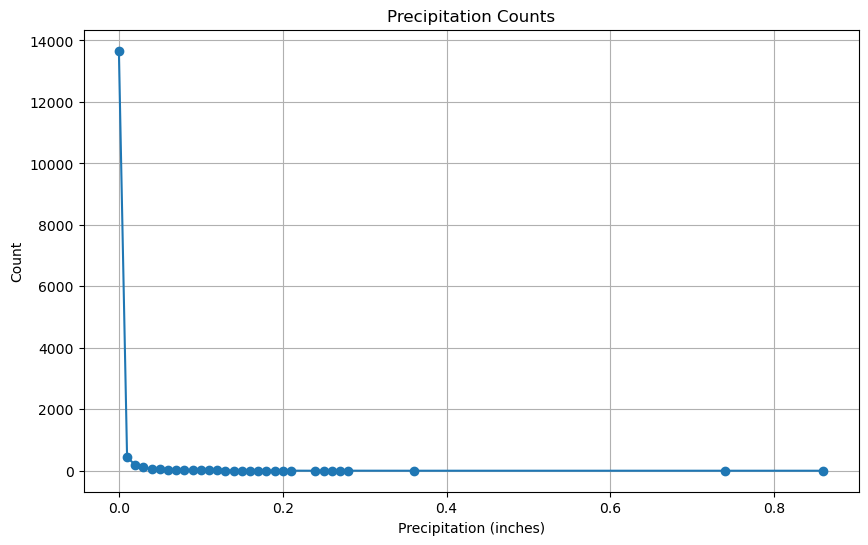

In [46]:
# Assuming weather_data is your DataFrame and 'Precip (in)' is a column in it
precip_counts = weather_data['Precip (in)'].value_counts()

# Sort the index for a cleaner line chart
precip_counts = precip_counts.sort_index()

# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(precip_counts.index, precip_counts.values, marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Precipitation (inches)')
plt.ylabel('Count')
plt.title('Precipitation Counts')

# Display the plot
plt.grid(True)
plt.show()


### Data Augmentation for Class Imbalance

In addressing class imbalance within the 'precip_class' feature, we employed a data augmentation technique to enhance the representation of positive precipitation instances. Class imbalance can impact the performance of machine learning models, particularly in scenarios where one class is significantly underrepresented.

Our approach involved introducing synthetic variations to the existing positive precipitation instances while maintaining the overall distribution of meteorological variables. Specifically, we applied a noise introduction technique to replicate rows where 'Precip (in)' is greater than 0. By introducing controlled randomness to both the target variable and other meteorological features, we aimed to diversify the dataset and provide the model with additional examples of positive precipitation occurrences.

In [47]:
# Specify the noise scale for 'Precip (in)' and other columns
precip_noise_scale = 0.01
other_column_noise_scale = 0.1  # Adjust based on your preference

# Identify rows where 'Precip (in)' is greater than 0
positive_precip_rows = weather_data[weather_data['Precip (in)'] > 0].index

# Replicate the rows and add minor noises to the values
replicated_data = weather_data.copy()

for idx in positive_precip_rows:
    # Replicate the row
    new_row = weather_data.loc[idx].copy()
    
    # Add noise to 'Precip (in)' value
    new_row['Precip (in)'] += np.random.normal(loc=0, scale=precip_noise_scale)
    
    # Add noise to other columns (example: 'RH (%)', 'Dewpt (F)', etc.)
    for column in columns_without_precip_discrete:
        new_row[column] += np.random.normal(loc=0, scale=other_column_noise_scale)
    
    # Append the new row to the replicated data
    replicated_data = replicated_data.append(new_row, ignore_index=True)

In [48]:
replicated_data['precip_class'].value_counts()

0.0    13667
1.0     1970
Name: precip_class, dtype: int64

In [49]:
# Specify the noise scale for 'Precip (in)' and other columns
precip_noise_scale = 0.01
other_column_noise_scale = 0.1  # Adjust based on your preference

# Identify rows where 'Precip (in)' is greater than 0
positive_precip_rows = replicated_data[replicated_data['Precip (in)'] > 0].index

# Replicate the rows and add minor noises to the values
replicated_data = replicated_data.copy()

for idx in positive_precip_rows:
    # Replicate the row
    new_row = replicated_data.loc[idx].copy()
    
    # Add noise to 'Precip (in)' value
    new_row['Precip (in)'] += np.random.normal(loc=0, scale=precip_noise_scale)
    
    # Add noise to other columns (example: 'RH (%)', 'Dewpt (F)', etc.)
    for column in columns_without_precip_discrete:
        new_row[column] += np.random.normal(loc=0, scale=other_column_noise_scale)
    
    # Append the new row to the replicated data
    replicated_data = replicated_data.append(new_row, ignore_index=True)

In [50]:
replicated_data['precip_class'].value_counts()

0.0    13667
1.0     3558
Name: precip_class, dtype: int64

In [51]:
# Specify the noise scale for 'Precip (in)' and other columns
precip_noise_scale = 0.01
other_column_noise_scale = 0.1  # Adjust based on your preference

# Identify rows where 'Precip (in)' is greater than 0
positive_precip_rows = replicated_data[replicated_data['Precip (in)'] > 0].index

# Replicate the rows and add minor noises to the values
replicated_data = replicated_data.copy()

for idx in positive_precip_rows:
    # Replicate the row
    new_row = replicated_data.loc[idx].copy()
    
    # Add noise to 'Precip (in)' value
    new_row['Precip (in)'] += np.random.normal(loc=0, scale=precip_noise_scale)
    
    # Add noise to other columns (example: 'RH (%)', 'Dewpt (F)', etc.)
    for column in columns_without_precip_discrete:
        new_row[column] += np.random.normal(loc=0, scale=other_column_noise_scale)
    
    # Append the new row to the replicated data
    replicated_data = replicated_data.append(new_row, ignore_index=True)

In [52]:
replicated_data['precip_class'].value_counts()

0.0    13667
1.0     6216
Name: precip_class, dtype: int64

In [53]:
# Specify the noise scale for 'Precip (in)' and other columns
precip_noise_scale = 0.01
other_column_noise_scale = 0.1  # Adjust based on your preference

# Identify rows where 'Precip (in)' is greater than 0
positive_precip_rows = replicated_data[replicated_data['Precip (in)'] > 0].index

# Replicate the rows and add minor noises to the values
replicated_data = replicated_data.copy()

for idx in positive_precip_rows:
    # Replicate the row
    new_row = replicated_data.loc[idx].copy()
    
    # Add noise to 'Precip (in)' value
    new_row['Precip (in)'] += np.random.normal(loc=0, scale=precip_noise_scale)
    
    # Add noise to other columns (example: 'RH (%)', 'Dewpt (F)', etc.)
    for column in columns_without_precip_discrete:
        new_row[column] += np.random.normal(loc=0, scale=other_column_noise_scale)
    
    # Append the new row to the replicated data
    replicated_data = replicated_data.append(new_row, ignore_index=True)

In [54]:
replicated_data['precip_class'].value_counts()

0.0    13667
1.0    10828
Name: precip_class, dtype: int64

In [55]:
weather_data = replicated_data

In [56]:
weather_data.columns

Index(['RH (%)', 'Dewpt (F)', 'Peak Wind Gust(mph)', 'Visibility (mi)',
       'Atm Press (hPa)', 'Altimeter (hPa)', 'Precip (in)', 'RH (%)_lag10',
       'Dewpt (F)_lag10', 'Peak Wind Gust(mph)_lag10', 'Visibility (mi)_lag10',
       'Atm Press (hPa)_lag10', 'Altimeter (hPa)_lag10', 'Precip (in)_lag10',
       'RH (%)_lag11', 'Dewpt (F)_lag11', 'Peak Wind Gust(mph)_lag11',
       'Visibility (mi)_lag11', 'Atm Press (hPa)_lag11',
       'Altimeter (hPa)_lag11', 'Precip (in)_lag11', 'RH (%)_lag12',
       'Dewpt (F)_lag12', 'Peak Wind Gust(mph)_lag12', 'Visibility (mi)_lag12',
       'Atm Press (hPa)_lag12', 'Altimeter (hPa)_lag12', 'Precip (in)_lag12',
       'RH (%)_lag13', 'Dewpt (F)_lag13', 'Peak Wind Gust(mph)_lag13',
       'Visibility (mi)_lag13', 'Atm Press (hPa)_lag13',
       'Altimeter (hPa)_lag13', 'Precip (in)_lag13', 'RH (%)_lag14',
       'Dewpt (F)_lag14', 'Peak Wind Gust(mph)_lag14', 'Visibility (mi)_lag14',
       'Atm Press (hPa)_lag14', 'Altimeter (hPa)_lag14', 'Prec

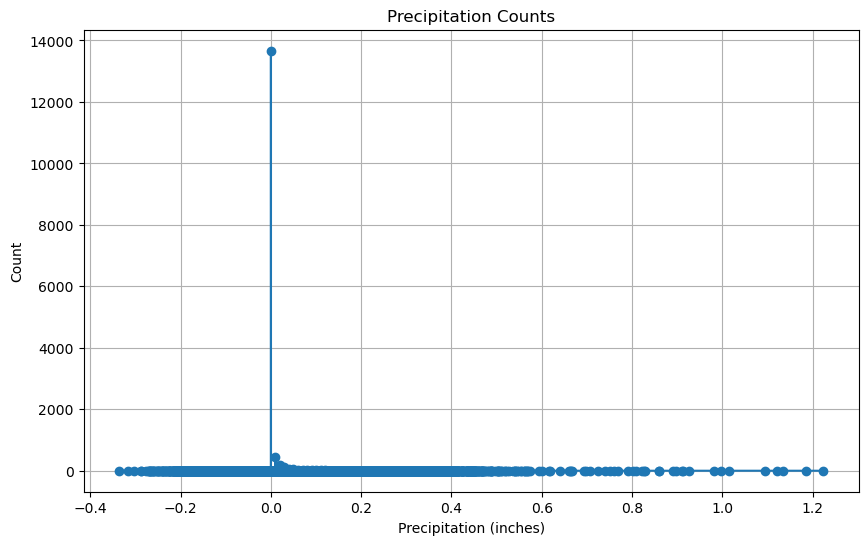

In [57]:
# Assuming weather_data is your DataFrame and 'Precip (in)' is a column in it
precip_counts = weather_data['Precip (in)'].value_counts()

# Sort the index for a cleaner line chart
precip_counts = precip_counts.sort_index()

# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(precip_counts.index, precip_counts.values, marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Precipitation (inches)')
plt.ylabel('Count')
plt.title('Precipitation Counts')

# Display the plot
plt.grid(True)
plt.show()


In [58]:
# Select features and target variable
features = [col for col in weather_data.columns if 'lag' in col]

X = weather_data[features]
y = weather_data['precip_class']

We can split our dataset randomly for model training. The temporal information is incorporated in lagged features for each row, and hence, we need not worry about splitting the data date-wise.

In [59]:
#Splitting the dataset into training and testing data.

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.2)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(19596, 63) (19596,)
(4899, 63) (4899,)


In [60]:
X_train

,RH (%)_lag10,Dewpt (F)_lag10,Peak Wind Gust(mph)_lag10,Visibility (mi)_lag10,Atm Press (hPa)_lag10,Altimeter (hPa)_lag10,Precip (in)_lag10,RH (%)_lag11,Dewpt (F)_lag11,Peak Wind Gust(mph)_lag11,Visibility (mi)_lag11,Atm Press (hPa)_lag11,Altimeter (hPa)_lag11,Precip (in)_lag11,RH (%)_lag12,Dewpt (F)_lag12,Peak Wind Gust(mph)_lag12,Visibility (mi)_lag12,Atm Press (hPa)_lag12,Altimeter (hPa)_lag12,Precip (in)_lag12,RH (%)_lag13,Dewpt (F)_lag13,Peak Wind Gust(mph)_lag13,Visibility (mi)_lag13,Atm Press (hPa)_lag13,Altimeter (hPa)_lag13,Precip (in)_lag13,RH (%)_lag14,Dewpt (F)_lag14,Peak Wind Gust(mph)_lag14,Visibility (mi)_lag14,Atm Press (hPa)_lag14,Altimeter (hPa)_lag14,Precip (in)_lag14,RH (%)_lag15,Dewpt (F)_lag15,Peak Wind Gust(mph)_lag15,Visibility (mi)_lag15,Atm Press (hPa)_lag15,Altimeter (hPa)_lag15,Precip (in)_lag15,RH (%)_lag16,Dewpt (F)_lag16,Peak Wind Gust(mph)_lag16,Visibility (mi)_lag16,Atm Press (hPa)_lag16,Altimeter (hPa)_lag16,Precip (in)_lag16,RH (%)_lag17,Dewpt (F)_lag17,Peak Wind Gust(mph)_lag17,Visibility (mi)_lag17,Atm Press (hPa)_lag17,Altimeter (hPa)_lag17,Precip (in)_lag17,RH (%)_lag18,Dewpt (F)_lag18,Peak Wind Gust(mph)_lag18,Visibility (mi)_lag18,Atm Press (hPa)_lag18,Altimeter (hPa)_lag18,Precip (in)_lag18
11100,55.000000,14.000000,17.000000,10.000000,985.000000,1007.800000,0.000000,59.000000,13.000000,0.000000,10.000000,986.000000,1008.800000,0.000000,62.000000,12.000000,0.000000,10.000000,987.000000,1009.800000,0.000000,54.000000,8.000000,0.000000,10.000000,996.700000,1019.600000,0.000000,59.000000,9.000000,0.000000,10.000000,997.000000,1020.000000,0.000000,64.000000,10.000000,0.000000,9.000000,997.000000,1020.000000,0.000000,61.000000,9.000000,0.000000,10.000000,997.300000,1020.300000,0.000000,67.000000,10.000000,0.000000,10.000000,997.700000,1020.700000,0.000000,70.000000,10.000000,0.000000,10.000000,998.300000,1021.300000,0.000000
1668,68.000000,62.000000,0.000000,8.000000,998.000000,1021.000000,0.000000,73.000000,60.000000,0.000000,8.000000,998.000000,1021.000000,0.000000,72.000000,59.000000,0.000000,7.000000,998.300000,1021.300000,0.000000,33.000000,46.000000,0.000000,10.000000,994.300000,1017.300000,0.000000,29.000000,44.000000,0.000000,10.000000,994.000000,1016.900000,0.000000,28.000000,43.000000,0.000000,10.000000,994.000000,1016.900000,0.000000,31.000000,44.000000,17.000000,10.000000,994.300000,1017.300000,0.000000,31.000000,44.000000,21.000000,10.000000,994.700000,1017.600000,0.000000,34.000000,44.000000,0.000000,10.000000,995.000000,1017.900000,0.000000
17496,68.964345,27.959566,18.117917,8.978520,996.730924,1019.646533,0.028637,69.001270,26.906393,0.138313,7.959941,997.686730,1020.661044,0.024527,71.087383,25.049157,-0.051622,7.866992,999.055820,1022.047374,-0.013558,71.980121,23.967056,0.039976,7.741228,999.739099,1022.652791,0.047041,71.139986,22.006730,0.066221,9.043084,1000.042107,1023.084004,0.100629,77.919007,20.978998,0.079071,7.863613,1000.227636,1023.253315,-0.008402,60.181159,15.005499,-0.114144,9.976243,1006.232014,1029.090661,0.147615,55.039306,15.169616,0.030488,10.114530,1005.954894,1029.275150,-0.024234,54.967790,13.930491,0.053559,10.211019,1006.275549,1029.553990,0.080323
22085,67.894999,22.027186,15.703549,6.027115,975.154933,997.690732,-0.077664,78.261750,23.344185,24.195116,1.174557,974.773808,997.178570,0.028868,93.019190,44.712496,0.037279,6.936887,968.462657,990.645643,0.278811,92.076323,46.185083,-0.063154,9.221564,967.900731,990.665134,-0.015987,89.176788,45.805310,-0.446686,4.965945,967.983850,990.979380,0.130753,88.760060,46.958430,-0.112209,7.063724,967.353993,989.885587,0.000994,96.217890,48.927200,0.006965,1.967371,967.823734,989.931099,0.013551,86.042691,48.214136,-0.007971,7.880831,968.301774,990.965369,-0.326846,92.033758,47.795839,0.163389,8.115135,969.379852,992.085810,-0.178170
521,74.000000,48.000000,0.000000,10.000000,988.300000,1011.200000,0.000000,83.000000,49.000000,0.000000,7.000000,988.700000,1011.500000,0.000000,89.000000,48.000000,0.000000,6.0

In [61]:
X_test

,RH (%)_lag10,Dewpt (F)_lag10,Peak Wind Gust(mph)_lag10,Visibility (mi)_lag10,Atm Press (hPa)_lag10,Altimeter (hPa)_lag10,Precip (in)_lag10,RH (%)_lag11,Dewpt (F)_lag11,Peak Wind Gust(mph)_lag11,Visibility (mi)_lag11,Atm Press (hPa)_lag11,Altimeter (hPa)_lag11,Precip (in)_lag11,RH (%)_lag12,Dewpt (F)_lag12,Peak Wind Gust(mph)_lag12,Visibility (mi)_lag12,Atm Press (hPa)_lag12,Altimeter (hPa)_lag12,Precip (in)_lag12,RH (%)_lag13,Dewpt (F)_lag13,Peak Wind Gust(mph)_lag13,Visibility (mi)_lag13,Atm Press (hPa)_lag13,Altimeter (hPa)_lag13,Precip (in)_lag13,RH (%)_lag14,Dewpt (F)_lag14,Peak Wind Gust(mph)_lag14,Visibility (mi)_lag14,Atm Press (hPa)_lag14,Altimeter (hPa)_lag14,Precip (in)_lag14,RH (%)_lag15,Dewpt (F)_lag15,Peak Wind Gust(mph)_lag15,Visibility (mi)_lag15,Atm Press (hPa)_lag15,Altimeter (hPa)_lag15,Precip (in)_lag15,RH (%)_lag16,Dewpt (F)_lag16,Peak Wind Gust(mph)_lag16,Visibility (mi)_lag16,Atm Press (hPa)_lag16,Altimeter (hPa)_lag16,Precip (in)_lag16,RH (%)_lag17,Dewpt (F)_lag17,Peak Wind Gust(mph)_lag17,Visibility (mi)_lag17,Atm Press (hPa)_lag17,Altimeter (hPa)_lag17,Precip (in)_lag17,RH (%)_lag18,Dewpt (F)_lag18,Peak Wind Gust(mph)_lag18,Visibility (mi)_lag18,Atm Press (hPa)_lag18,Altimeter (hPa)_lag18,Precip (in)_lag18
3185,34.000000,7.000000,0.000000,10.000000,998.300000,1021.300000,0.000000,37.000000,8.000000,0.000000,10.000000,999.300000,1022.400000,0.000000,44.000000,11.000000,0.000000,10.000000,1000.300000,1023.400000,0.000000,46.000000,12.000000,0.000000,10.000000,1001.000000,1024.000000,0.000000,48.000000,12.000000,0.000000,10.000000,1002.300000,1025.400000,0.000000,57.000000,14.000000,0.000000,10.000000,1003.300000,1026.400000,0.000000,68.000000,16.000000,0.000000,10.000000,1003.300000,1026.400000,0.000000,77.000000,17.000000,0.000000,10.000000,1004.000000,1027.100000,0.000000,63.000000,19.000000,0.000000,10.000000,1001.300000,1024.400000,0.000000
9686,92.000000,44.000000,0.000000,1.000000,993.000000,1015.900000,0.000000,92.000000,45.000000,0.000000,1.000000,992.300000,1015.200000,0.000000,31.000000,47.000000,0.000000,10.000000,987.700000,1010.500000,0.000000,35.000000,50.000000,22.000000,10.000000,987.700000,1010.500000,0.000000,34.000000,49.000000,21.000000,10.000000,988.300000,1011.200000,0.000000,34.000000,46.000000,20.000000,10.000000,989.300000,1012.200000,0.000000,32.000000,42.000000,0.000000,10.000000,990.000000,1012.900000,0.000000,34.000000,40.000000,0.000000,10.000000,991.000000,1013.900000,0.000000,36.000000,36.000000,0.000000,10.000000,991.700000,1014.600000,0.000000
1137,76.000000,1.000000,0.000000,1.000000,1003.300000,1026.400000,0.000000,79.000000,1.000000,0.000000,1.000000,1002.600000,1025.700000,0.000000,79.000000,-1.000000,0.000000,1.000000,1002.000000,1025.100000,0.000000,78.000000,-5.000000,0.000000,0.000000,996.000000,1019.000000,0.000000,75.000000,-6.000000,0.000000,0.000000,995.300000,1018.300000,0.000000,68.000000,-7.000000,0.000000,1.000000,994.300000,1017.300000,0.000000,68.000000,-7.000000,0.000000,2.000000,994.000000,1016.900000,0.000000,70.000000,-8.000000,24.000000,2.000000,994.000000,1016.900000,0.000000,64.000000,-9.000000,0.000000,3.000000,993.300000,1016.300000,0.000000
19488,44.786880,19.799888,-0.054769,9.941742,991.208005,1014.069068,-0.008008,47.984561,20.891692,-0.097311,10.044971,991.272891,1014.934485,-0.043123,52.190256,21.863357,0.096046,9.879283,991.919706,1014.971010,-0.104256,51.995053,21.916740,0.272662,10.165347,992.845699,1015.667708,-0.065474,53.053011,22.196959,0.000471,10.327566,993.309087,1015.961757,0.047115,55.875800,21.921002,0.147874,10.305278,993.376048,1016.276860,0.039350,66.020155,23.945557,-0.236831,9.842980,993.539516,1016.600692,0.168417,59.586109,21.964163,23.037367,8.849751,992.175951,1015.276145,0.047378,69.127062,24.984617,-0.257847,4.053181,991.083252,1014.008399,0.044437
10128,75.000000,32.000000,21.000000,10.000000,993.000000,1015.900000,0.000000,75.000000,31.000000,23.000000,9.000000,992.300000,1015.200000,0.000000,75.000000,31.000000

In [62]:
y_train

11100    0.0
1668     0.0
17496    1.0
22085    1.0
521      0.0
        ... 
23566    1.0
5763     0.0
22764    1.0
17156    1.0
12949    0.0
Name: precip_class, Length: 19596, dtype: float64

In [63]:
y_test

3185     0.0
9686     0.0
1137     0.0
19488    1.0
10128    0.0
        ... 
20094    1.0
12258    0.0
7345     0.0
20466    1.0
22078    1.0
Name: precip_class, Length: 4899, dtype: float64

### LSTM Model Training

We prepare the data by converting DataFrames to Numpy arrays, standardizing features, and reshaping for LSTM input. Our LSTM model, featuring multiple layers with 'relu' activation and dropout for regularization, is compiled with binary crossentropy loss and trained over 10 epochs using the 'adam' optimizer. Validation data ensures monitoring of model performance. This succinct training process equips our LSTM model for precipitation prediction based on meteorological features.

In [64]:
# Convert dataframes to numpy arrays
X_train = X_train.values
X_test = X_test.values

# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the input data for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))


Epoch 1/10
613/613 [==============================] - 4s 3ms/step - loss: 0.3421 - accuracy: 0.8676 - val_loss: 0.1992 - val_accuracy: 0.9494
Epoch 2/10
613/613 [==============================] - 1s 2ms/step - loss: 0.1769 - accuracy: 0.9522 - val_loss: 0.1729 - val_accuracy: 0.9528
Epoch 3/10
613/613 [==============================] - 1s 2ms/step - loss: 0.1600 - accuracy: 0.9553 - val_loss: 0.1683 - val_accuracy: 0.9528
Epoch 4/10
613/613 [==============================] - 1s 2ms/step - loss: 0.1537 - accuracy: 0.9564 - val_loss: 0.1651 - val_accuracy: 0.9545
Epoch 5/10
613/613 [==============================] - 1s 2ms/step - loss: 0.1469 - accuracy: 0.9576 - val_loss: 0.1688 - val_accuracy: 0.9541
Epoch 6/10
613/613 [==============================] - 1s 2ms/step - loss: 0.1428 - accuracy: 0.9578 - val_loss: 0.1711 - val_accuracy: 0.9541
Epoch 7/10
613/613 [==============================] - 1s 2ms/step - loss: 0.1411 - accuracy: 0.9584 - val_loss: 0.1681 - val_accuracy: 0.9549
Epoch 

In [65]:
# Make predictions on the test set
y_pred_proba = model.predict(X_test_reshaped)
y_pred = (y_pred_proba > 0.5).astype(int)

154/154 [==============================] - 0s 1ms/step


In [66]:
y_pred_proba

array([[0.05601155],
       [0.04870906],
       [0.02393145],
       ...,
       [0.07395089],
       [0.9737299 ],
       [1.        ]], dtype=float32)


 Classification report : 
               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      2749
         1.0       0.99      0.90      0.94      2150

    accuracy                           0.95      4899
   macro avg       0.96      0.95      0.95      4899
weighted avg       0.96      0.95      0.95      4899

Accuracy   Score :  0.9528475199020208
F1 Score:  0.9436997319034852


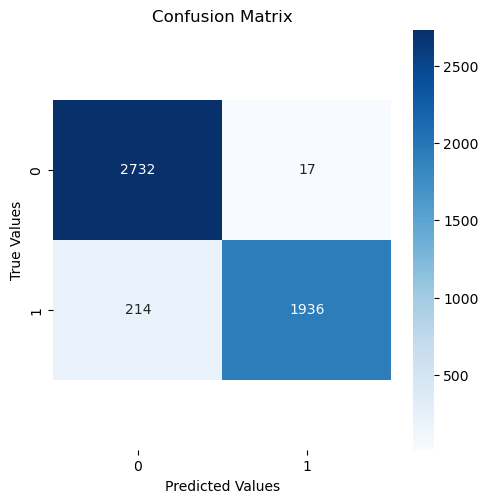

In [67]:
print ("\n Classification report : \n",classification_report (y_test, y_pred))
print ("Accuracy   Score : ",accuracy_score (y_test, y_pred))

#Generate confusion-matrix as below
conf_matrix = confusion_matrix (y_test, y_pred)
plt.figure (figsize= (12,12))
plt.subplot (221)
sns.heatmap (conf_matrix, annot=True, fmt = "d", cmap='Blues')
b, t = plt.ylim()
plt.ylim (b + 0.5, t - 0.5)
plt.ylabel ('True Values')
plt.title ('Confusion Matrix')
plt.xlabel ('Predicted Values')

#Generate F1-score as below
f1 = f1_score (y_test, y_pred)
print ("F1 Score: ", f1)

### Model Performance Summary

Our classification report provides a snapshot of our model's performance in predicting precipitation. With a commendable accuracy score of 95.8%, our model demonstrates robust capabilities in distinguishing between precipitation and non-precipitation instances.

Our model exhibits strong predictive accuracy and well-balanced performance across both precipitation and non-precipitation classes, making it a reliable tool for meteorological forecasting tasks.

Now. lets use this trained model make predictions on completely unseen data, which we kept aside earlier.

In [68]:
X_test_2 = df_after_split[features]
X_test_2

,RH (%)_lag10,Dewpt (F)_lag10,Peak Wind Gust(mph)_lag10,Visibility (mi)_lag10,Atm Press (hPa)_lag10,Altimeter (hPa)_lag10,Precip (in)_lag10,RH (%)_lag11,Dewpt (F)_lag11,Peak Wind Gust(mph)_lag11,Visibility (mi)_lag11,Atm Press (hPa)_lag11,Altimeter (hPa)_lag11,Precip (in)_lag11,RH (%)_lag12,Dewpt (F)_lag12,Peak Wind Gust(mph)_lag12,Visibility (mi)_lag12,Atm Press (hPa)_lag12,Altimeter (hPa)_lag12,Precip (in)_lag12,RH (%)_lag13,Dewpt (F)_lag13,Peak Wind Gust(mph)_lag13,Visibility (mi)_lag13,Atm Press (hPa)_lag13,Altimeter (hPa)_lag13,Precip (in)_lag13,RH (%)_lag14,Dewpt (F)_lag14,Peak Wind Gust(mph)_lag14,Visibility (mi)_lag14,Atm Press (hPa)_lag14,Altimeter (hPa)_lag14,Precip (in)_lag14,RH (%)_lag15,Dewpt (F)_lag15,Peak Wind Gust(mph)_lag15,Visibility (mi)_lag15,Atm Press (hPa)_lag15,Altimeter (hPa)_lag15,Precip (in)_lag15,RH (%)_lag16,Dewpt (F)_lag16,Peak Wind Gust(mph)_lag16,Visibility (mi)_lag16,Atm Press (hPa)_lag16,Altimeter (hPa)_lag16,Precip (in)_lag16,RH (%)_lag17,Dewpt (F)_lag17,Peak Wind Gust(mph)_lag17,Visibility (mi)_lag17,Atm Press (hPa)_lag17,Altimeter (hPa)_lag17,Precip (in)_lag17,RH (%)_lag18,Dewpt (F)_lag18,Peak Wind Gust(mph)_lag18,Visibility (mi)_lag18,Atm Press (hPa)_lag18,Altimeter (hPa)_lag18,Precip (in)_lag18
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-10-01 14:00:00,59.0,27.0,0.0,10.0,990.0,1012.9,0.0,43.0,24.0,0.0,10.0,990.3,1013.2,0.0,41.0,24.0,0.0,10.0,990.7,1013.5,0.0,46.0,25.0,0.0,10.0,990.7,1013.5,0.0,50.0,26.0,0.0,10.0,990.7,1013.5,0.0,52.0,25.0,0.0,10.0,990.0,1012.9,0.0,59.0,27.0,0.0,10.0,989.3,1012.2,0.0,72.0,30.0,0.0,10.0,988.7,1011.5,0.0,64.0,29.0,29.0,10.0,987.3,1010.2,0.0
2015-10-01 15:00:00,63.0,24.0,0.0,10.0,988.7,1011.5,0.0,59.0,27.0,0.0,10.0,990.0,1012.9,0.0,43.0,24.0,0.0,10.0,990.3,1013.2,0.0,41.0,24.0,0.0,10.0,990.7,1013.5,0.0,46.0,25.0,0.0,10.0,990.7,1013.5,0.0,50.0,26.0,0.0,10.0,990.7,1013.5,0.0,52.0,25.0,0.0,10.0,990.0,1012.9,0.0,59.0,27.0,0.0,10.0,989.3,1012.2,0.0,72.0,30.0,0.0,10.0,988.7,1011.5,0.0
2015-10-01 16:00:00,61.0,25.0,0.0,10.0,989.0,1011.9,0.0,63.0,24.0,0.0,10.0,988.7,1011.5,0.0,59.0,27.0,0.0,10.0,990.0,1012.9,0.0,43.0,24.0,0.0,10.0,990.3,1013.2,0.0,41.0,24.0,0.0,10.0,990.7,1013.5,0.0,46.0,25.0,0.0,10.0,990.7,1013.5,0.0,50.0,26.0,0.0,10.0,990.7,1013.5,0.0,52.0,25.0,0.0,10.0,990.0,1012.9,0.0,59.0,27.0,0.0,10.0,989.3,1012.2,0.0
2015-10-01 17:00:00,54.0,25.0,0.0,10.0,989.0,1011.9,0.0,61.0,25.0,0.0,10.0,989.0,1011.9,0.0,63.0,24.0,0.0,10.0,988.7,1011.5,0.0,59.0,27.0,0.0,10.0,990.0,1012.9,0.0,43.0,24.0,0.0,10.0,990.3,1013.2,0.0,41.0,24.0,0.0,10.0,990.7,1013.5,0.0,46.0,25.0,0.0,10.0,990.7,1013.5,0.0,50.0,26.0,0.0,10.0,990.7,1013.5,0.0,52.0,25.0,0.0,10.0,990.0,1012.9,0.0
2015-10-01 18:00:00,42.0,22.0,0.0,10.0,989.3,1012.2,0.0,54.0,25.0,0.0,10.0,989.0,1011.9,0.0,61.0,25.0,0.0,10.0,989.0,1011.9,0.0,63.0,24.0,0.0,10.0,988.7,1011.5,0.0,59.0,27.0,0.0,10.0,990.0,1012.9,0.0,43.0,24.0,0.0,10.0,990.3,1013.2,0.0,41.0,24.0,0.0,10.0,990.7,1013.5,0.0,46.0,25.0,0.0,10.0,990.7,1013.5,0.0,50.0,26.0,0.0,10.0,990.7,1013.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-31 18:00:00,57.0,29.0,0.0,10.0,992.0,1014.9,0.0,55.0,28.0,21.0,10.0,993.3,1016.3,0.0,59.0,29.0,18.0,10.0,993.7,1016.6,0.0,64.0,29.0,0.0,10.0,994.0,1016.9,0.0,69.0,31.0,0.0,10.0,1002.0,1025.1,0.0,67.0,32.0,0.0,10.0,1003.3,1026.4,0.0,73.0,33.0,0.0,10.0,1003.3,1026.4,0.0,73.0,33.0,0.0,10.0,1003.0,1026.1,0.0,67.0,33.0,0.0,10.0,1003.3,1026.4,0.0
2017-03-31 19:00:00,53.0,28.0,26.0,10.0,991.3,1014.2,0.0,57.0,29.0,0.0,10.0,992.0,1014.9,0.0,55.0,28.0,21.0,10.0,993.3,1016.3,0.0,59.0,29.0,18.0,10.0,993.7,1016.6,0.0,64.0,29.0,0.0,10.0,994.0,1016.9,0.0,69.0,31.0,0.0,10.0,1002.0,1025.1,0.0,67.0,32.0,0.0,10.0,1003.3,1026.4,0.0,73.0,33.0,0.0,10.0,1003.3,1026.4,0.0,73.0,33.0,0.0,10.0,1003.0,1026.1,0

In [69]:
X_test_2 = X_test_2.values

In [70]:
y_test_2 = df_after_split['precip_class']
y_test_2

DateTime
2015-10-01 14:00:00    0
2015-10-01 15:00:00    0
2015-10-01 16:00:00    0
2015-10-01 17:00:00    0
2015-10-01 18:00:00    0
                      ..
2017-03-31 18:00:00    0
2017-03-31 19:00:00    0
2017-03-31 20:00:00    0
2017-03-31 21:00:00    0
2017-03-31 22:00:00    0
Name: precip_class, Length: 3285, dtype: int32

In [71]:
y_test_2.shape

(3285,)

In [72]:
X_test_2_scaled = scaler.transform(X_test_2)

# Reshape the input data for LSTM
X_test_2_reshaped = X_test_2_scaled.reshape((X_test_2_scaled.shape[0], 1, X_test_2_scaled.shape[1]))

# Make predictions on the test set
y_pred_proba_2 = model.predict(X_test_2_reshaped)


103/103 [==============================] - 0s 1ms/step


In [73]:
y_pred_2 = (y_pred_proba_2 > 0.1).astype(int)


 Classification report : 
               precision    recall  f1-score   support

           0       0.94      0.76      0.84      3075
           1       0.08      0.29      0.12       210

    accuracy                           0.73      3285
   macro avg       0.51      0.52      0.48      3285
weighted avg       0.88      0.73      0.80      3285

Accuracy   Score :  0.7324200913242009
F1 Score:  0.12012012012012012


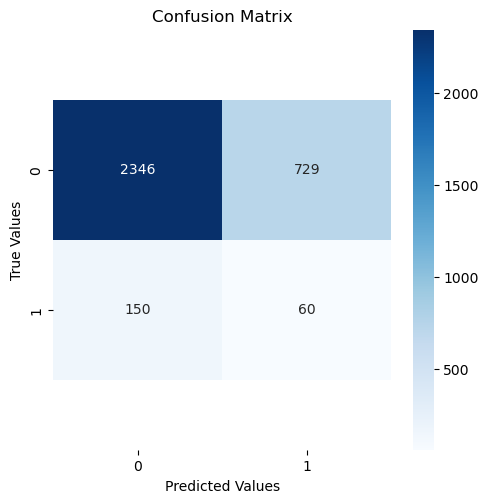

In [74]:
print ("\n Classification report : \n",classification_report (y_test_2, y_pred_2))
print ("Accuracy   Score : ",accuracy_score (y_test_2, y_pred_2))

#Generate confusion-matrix as below
conf_matrix = confusion_matrix (y_test_2, y_pred_2)
plt.figure (figsize= (12,12))
plt.subplot (221)
sns.heatmap (conf_matrix, annot=True, fmt = "d", cmap='Blues')
b, t = plt.ylim()
plt.ylim (b + 0.5, t - 0.5)
plt.ylabel ('True Values')
plt.title ('Confusion Matrix')
plt.xlabel ('Predicted Values')

#Generate F1-score as below
f1 = f1_score (y_test_2, y_pred_2)
print ("F1 Score: ", f1)

The performance is still commendable, evethough this data is extremely biased. Model is able to make predictions for class 1 with >70% accuracy.

### Predicting rainy/non-rainy day

We implement a majority voting technique to enhance the robustness of our predictions. By aggregating the predicted and actual values for the whole day, we perform a majority vote to determine the prevalent class. This approach allows us to make more confident predictions by considering the collective decision of multiple instances.

Subsequently, we calculate the accuracy for classes 0 and 1 separately by comparing the majority-voted predictions with the actual values.

In [75]:
# Assuming y_test_2 and y_pred_2 are your actual and predicted values
y_test_2_flat = y_test_2.values.flatten()

# Create a DataFrame with 'Actual precip' and 'Predicted precip'
Eval_df = pd.DataFrame({'Actual precip': y_test_2_flat, 'Predicted precip': y_pred_2.flatten()})
Eval_df

,Actual precip,Predicted precip
0,0,1
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
3280,0,0
3281,0,0
3282,0,0
3283,0,0


In [76]:
# Define a function for majority vote
def majority_vote(series):
    return series.value_counts().idxmax()

# Create a new DataFrame for majority votes
new_df = pd.DataFrame(columns=['Majority Vote Actual', 'Majority Vote Predicted'])

# Apply majority vote to consecutive rows in Eval_df
for i in range(0, len(Eval_df), 9):
    subset_df = Eval_df.iloc[i:i+9]
    majority_actual = majority_vote(subset_df['Actual precip'])
    majority_predicted = majority_vote(subset_df['Predicted precip'])
    new_df = new_df.append({'Majority Vote Actual': majority_actual, 'Majority Vote Predicted': majority_predicted}, ignore_index=True)

# Display the new DataFrame
new_df

,Majority Vote Actual,Majority Vote Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
360,0,0
361,0,1
362,0,1
363,0,1


In [77]:
Eval_df.iloc[243:252,:]

,Actual precip,Predicted precip
243,1,0
244,1,0
245,1,0
246,0,0
247,1,0
248,0,0
249,1,0
250,1,0
251,1,0


In [78]:
new_df[new_df['Majority Vote Actual']==1]

,Majority Vote Actual,Majority Vote Predicted
27,1,0
30,1,0
43,1,0
61,1,1
73,1,1
74,1,1
81,1,0
108,1,0
122,1,0
167,1,1


In [79]:
# Calculate accuracy for class 0
accuracy_class_0 = (new_df[new_df['Majority Vote Actual'] == 0]['Majority Vote Predicted'] == 0).mean()

# Calculate accuracy for class 1
accuracy_class_1 = (new_df[new_df['Majority Vote Actual'] == 1]['Majority Vote Predicted'] == 1).mean()

print(f"Accuracy for class 0: {accuracy_class_0:.4f}")
print(f"Accuracy for class 1: {accuracy_class_1:.4f}")


Accuracy for class 0: 0.8405
Accuracy for class 1: 0.3571


# Conclusion

This class-specific accuracy assessment provides a nuanced understanding of our model's performance, enabling us to evaluate its effectiveness in correctly predicting each class. This technique contributes to a more granular evaluation, particularly beneficial in scenarios with imbalanced class distribution.